# Problema 1 - Análisis de Desinformación en Redes Sociales en las Elecciones Presidenciales

## *Autores*: 
- _Leonardo Ponce 202030531-5 (leonardo.ponde@usm.cl)_
- _Álvaro Pozo 202030535-8 (alvaro.pozo@usm.cl)_


## Contexto

En el marco de las elecciones presidenciales, las redes sociales han adquirido un rol
central como espacio de difusión de información, debate y propaganda política. Sin
embargo, también se han convertido en terreno fértil para la circulación de noticias
falsas (fake news), campañas de desinformación coordinada y el uso de cuentas
automatizadas (bots) que distorsionan la conversación pública.
Este problema busca que analicen cómo se propaga este tipo de información, qué
actores y comunidades la potencian, y cómo es posible identificar patrones ocultos
mediante el uso de redes, análisis temporal y procesamiento de texto.

## Objetivos

En esta primera parte se trabajará con datos de redes sociales asociados a las elecciones presidenciales. El foco está en estudiar cómo se propagan las noticias falsas en comparación con publicaciones legítimas.

Tareas principales:
1. Recolectar y organizar publicaciones relevantes sobre las elecciones (ej., con
palabras clave o enlaces compartidos).
2. Reconstruir cascadas de difusión (retuits, compartidos, menciones) como
grafos de propagación.
3. Calcular métricas de red (grado, betweenness, closeness, etc.) para identificar
actores que amplifican rumores.
4. Visualizar la dinámica temporal y geográfica de la propagación.
5. Distinguir posibles cuentas automatizadas a partir de sus patrones de actividad.


# Desarrollo del problema

## Parte 1

### Recolección de información

Para el desarrollo del problema fue necesario diseñar un proceso robusto de **recolección de información** que permitiera obtener publicaciones reales desde redes sociales vinculadas a las elecciones presidenciales en Chile durante el año 2025.  

En una primera etapa, se **evaluaron distintas alternativas** para determinar la plataforma más adecuada. Inicialmente se consideró **Threads**, sin embargo, al realizar pruebas exploratorias se observó que esta red social presentaba **muy baja interacción y escaso volumen de publicaciones**, lo que dificultaba la construcción de **cascadas de difusión** y análisis de redes.  
Debido a esto, se optó finalmente por **Twitter (actualmente X)**, dado que constituye el principal espacio de discusión política en línea y cuenta con un ecosistema más activo de usuarios, interacciones y datos públicos accesibles.

Posteriormente, se analizaron **diversos métodos de extracción de datos** desde Twitter:

1. **Uso de la API oficial de Twitter/X**  
   Fue la primera alternativa considerada, ya que permite un acceso estructurado y controlado a la información. No obstante, en la actualidad la API gratuita posee una **limitación de solo 100 tweets por consulta**, lo cual imposibilita la recopilación de un volumen representativo de datos para este tipo de estudio.

2. **Empleo de la librería `snscrape`**  
   Esta herramienta era ampliamente utilizada para extraer información de Twitter sin necesidad de autenticación, pero **dejó de funcionar correctamente** luego de los cambios implementados por Elon Musk al modificar la arquitectura del sitio y renombrar la plataforma a X. Dado que `snscrape` ya no se encuentra actualizada, su uso no fue viable.

3. **Automatización mediante `Selenium`**  
   Se exploró la posibilidad de **simular la navegación humana** (scroll, clics, carga dinámica) con el objetivo de recolectar tweets directamente desde el navegador. Sin embargo, este enfoque presentó múltiples desafíos técnicos:  
   - **Riesgo elevado de bloqueo o baneo de cuentas**, especialmente si no se configuraban adecuadamente los *proxies*.  
   - **Dependencia del inicio de sesión**, ya que sin autenticación el acceso a publicaciones era extremadamente limitado.  
   - **Dificultades con el contenido dinámico en JavaScript**, que hacía el proceso inestable y fácilmente detectable por la plataforma.  
   Por estas razones, este método fue descartado por su alto riesgo y baja eficiencia para la escala de datos requerida.

Frente a estas limitaciones, se decidió utilizar la herramienta **Octoparse**, la cual ofrece una interfaz gráfica intuitiva que permite **automatizar el proceso de extracción de datos** sin necesidad de programar manualmente scripts complejos.  
Mediante esta plataforma se configuraron **búsquedas semánticas utilizando palabras clave relacionadas con el contexto electoral chileno de 2025**, lo que permitió acceder directamente a publicaciones de interés dentro del dominio de Twitter.

A través de este procedimiento se logró **extraer más de 6.000 tweets** relevantes, los cuales constituyen la base del análisis posterior de **propagación de información y desinformación**, permitiendo estudiar las dinámicas de interacción, la identificación de comunidades y la caracterización de cuentas automatizadas (bots) dentro del debate digital.


### Lectura de dataset

Leer datas de archivos CSV que contienen tweets desde twitter ("X")

In [ ]:
import pandas as pd
import numpy as np
data1 = pd.read_csv('../data/Tweets_Elecciones2025_Chile.csv')

In [ ]:
# verificar si hay filas duplicadas para eliminarlas
print(data1.duplicated().sum())

0


In [ ]:
print("Filas:", data1.shape)
print("Columnas:")
print(data1.columns.tolist())
print(data1.iloc[0])

Filas: (6572, 24)
Columnas:
['Query_Str', 'Post_URL', 'Author_Name', 'Author_Web_Page_URL', 'Author_Handle', 'Verified_Status', 'UTC_Time', 'Ads', 'Tweet_Content', 'Post_ID', 'Tweet_URL', 'Reply_Count', 'Repost_Count', 'Like_Count', 'View_Count', 'Bookmark_Count', 'Tweet_Image_URL', 'Replying_to', 'Reply_to_Whom', 'Reply_to_Whom_URL', 'Reply_to_Whom_Username', 'Reply_to_Whom_Handle', 'Language', 'Type']
Query_Str                 elecciones presidenciales chile matthei desinf...
Post_URL                  https://x.com/search?q=elecciones presidencial...
Author_Name                                        Make Chile 5K Again 🖐️🇨🇱
Author_Web_Page_URL                              https://x.com/Kasterizador
Author_Handle                                                  Kasterizador
Verified_Status                                                       False
UTC_Time                                          2025-01-06 17:03:24+00:00
Ads                                                          

### Reconstrucción de cascadas de difusión

Este bloque construye un grafo dirigido de respuestas (de Reply_to_Whom_Handle a Author_Handle) para representar las cascadas de difusión de tweets. Ordena las raíces por el tamaño de su cascada y visualiza las más grandes con un layout jerárquico, donde el tamaño de los nodos refleja su influencia.

Con estas gráficas se observa el alcance de los rumores (cantidad y profundidades) y la velocidad de propagación. Los usuarios con muchos descendientes actúan como principales difusores, y las ramas muy amplias o repetitivas pueden indicar actividad automatizada o coordinada. En síntesis, este código permite analizar quién inicia, amplifica y cómo se propaga una noticia falsa frente a publicaciones veridicas

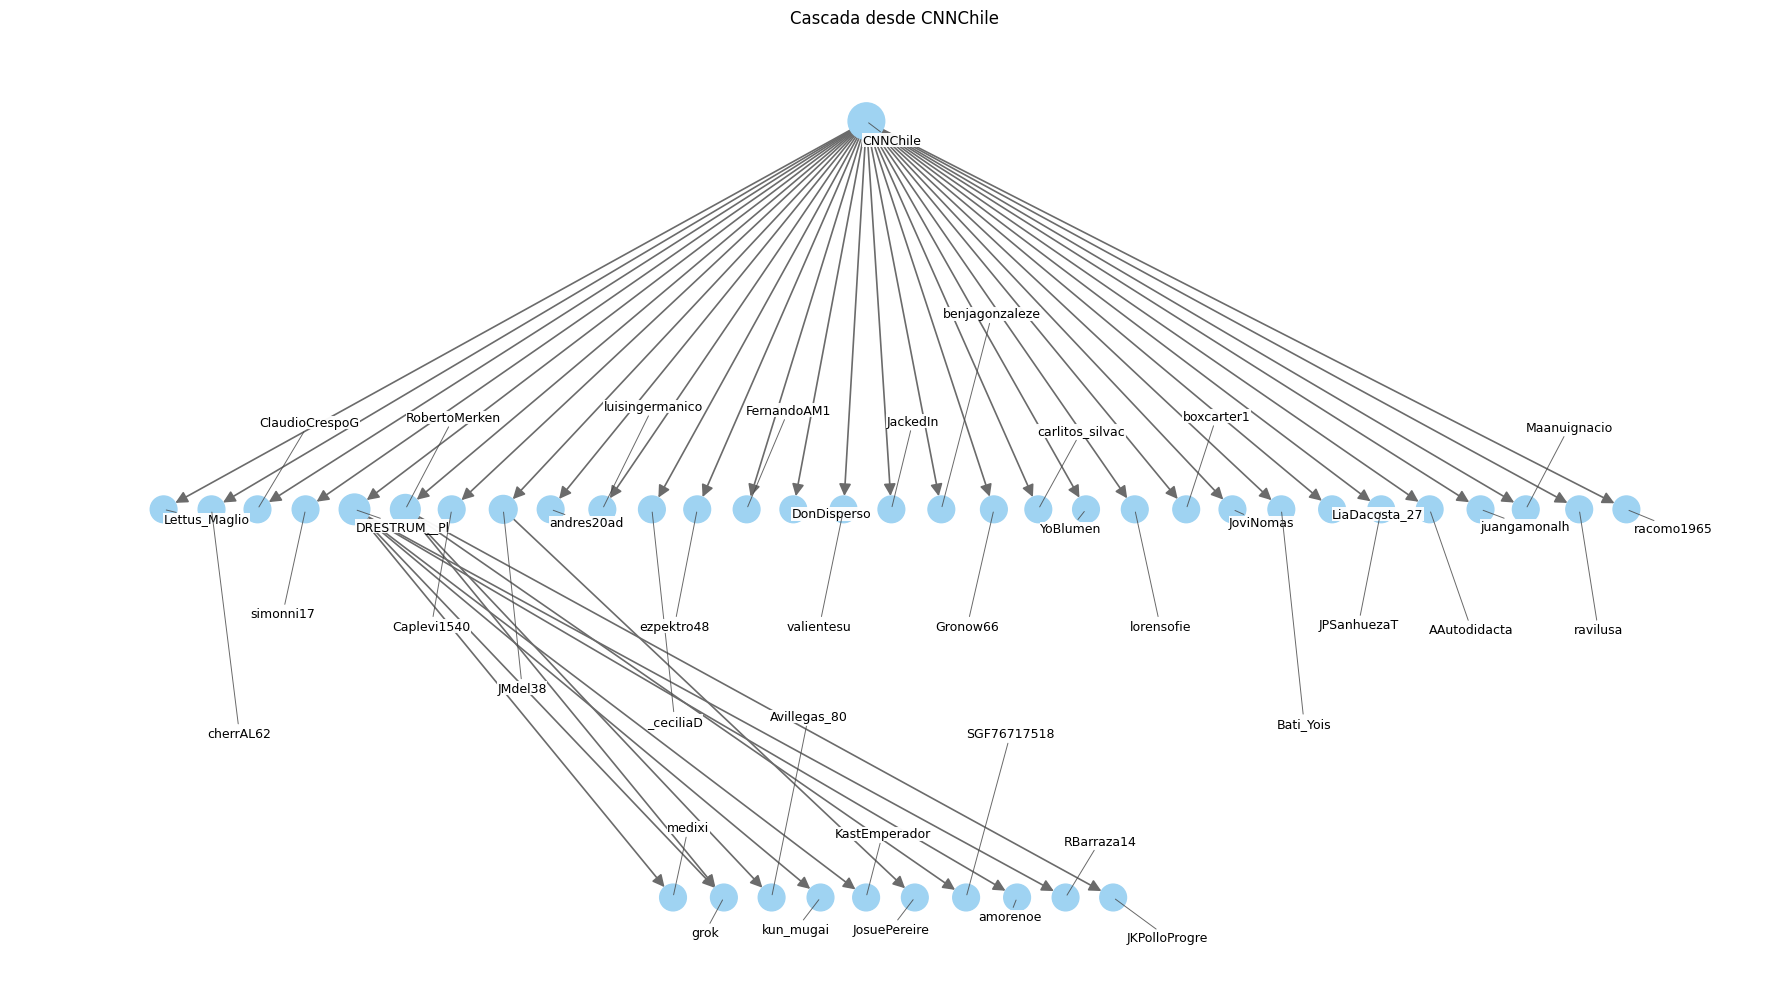

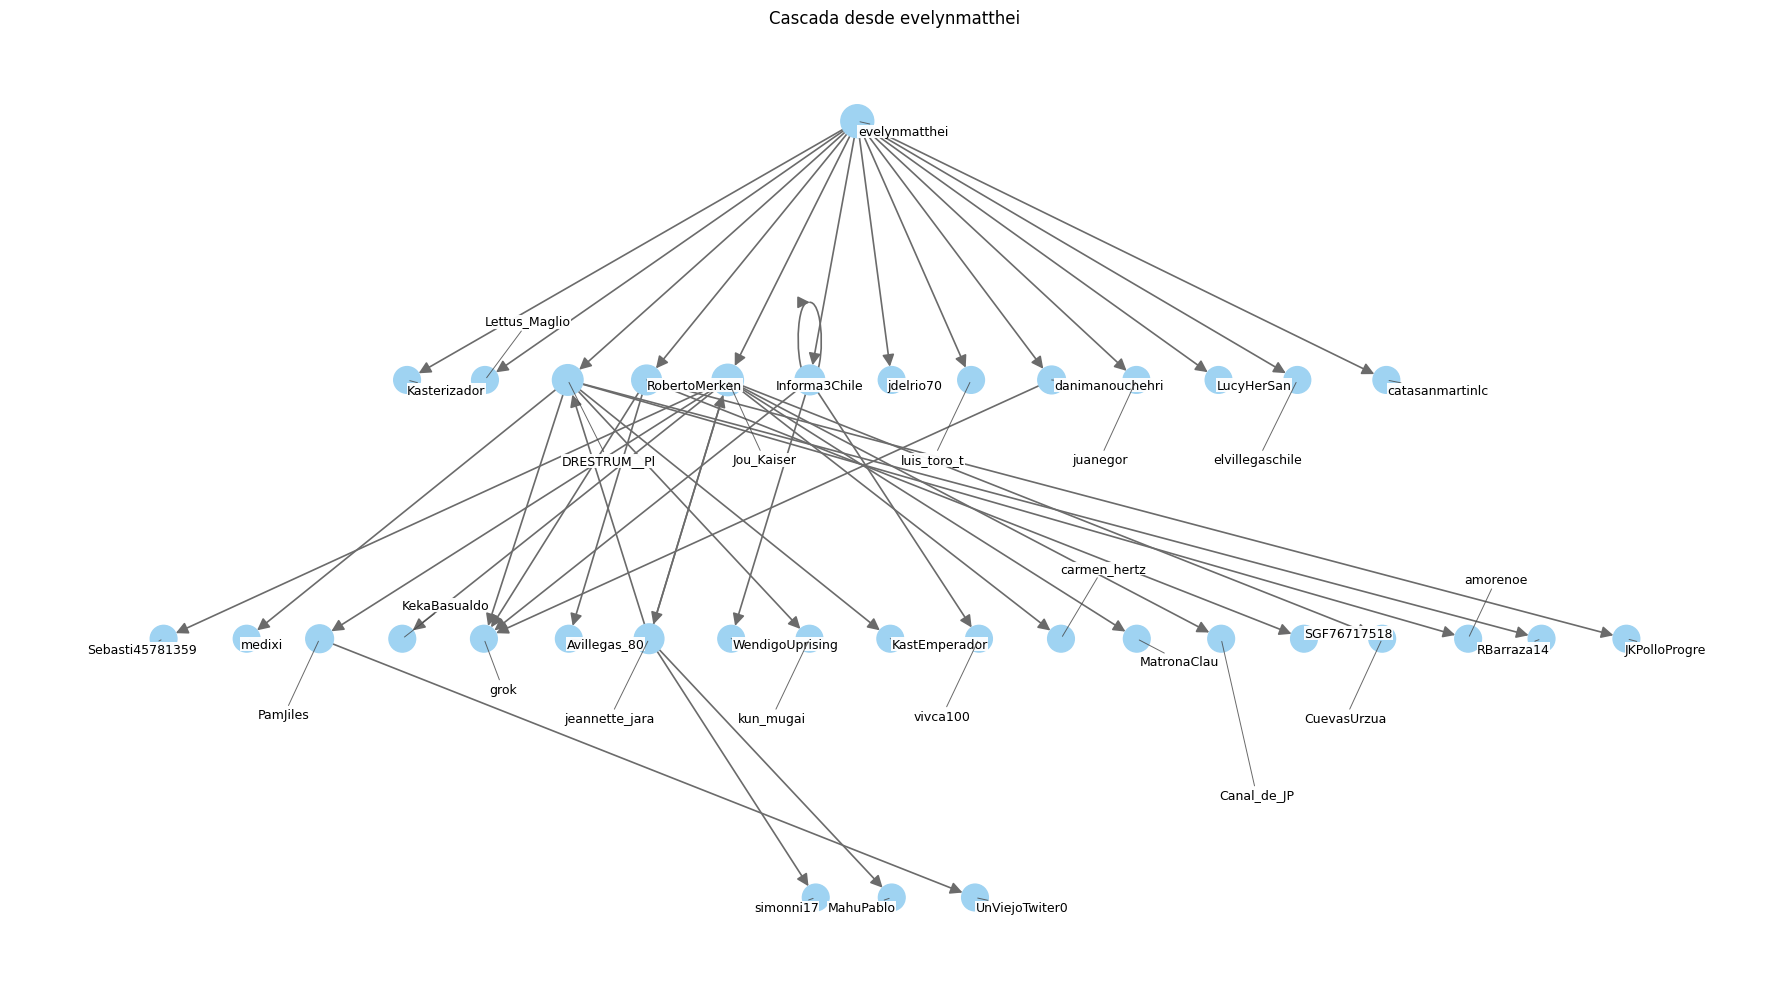

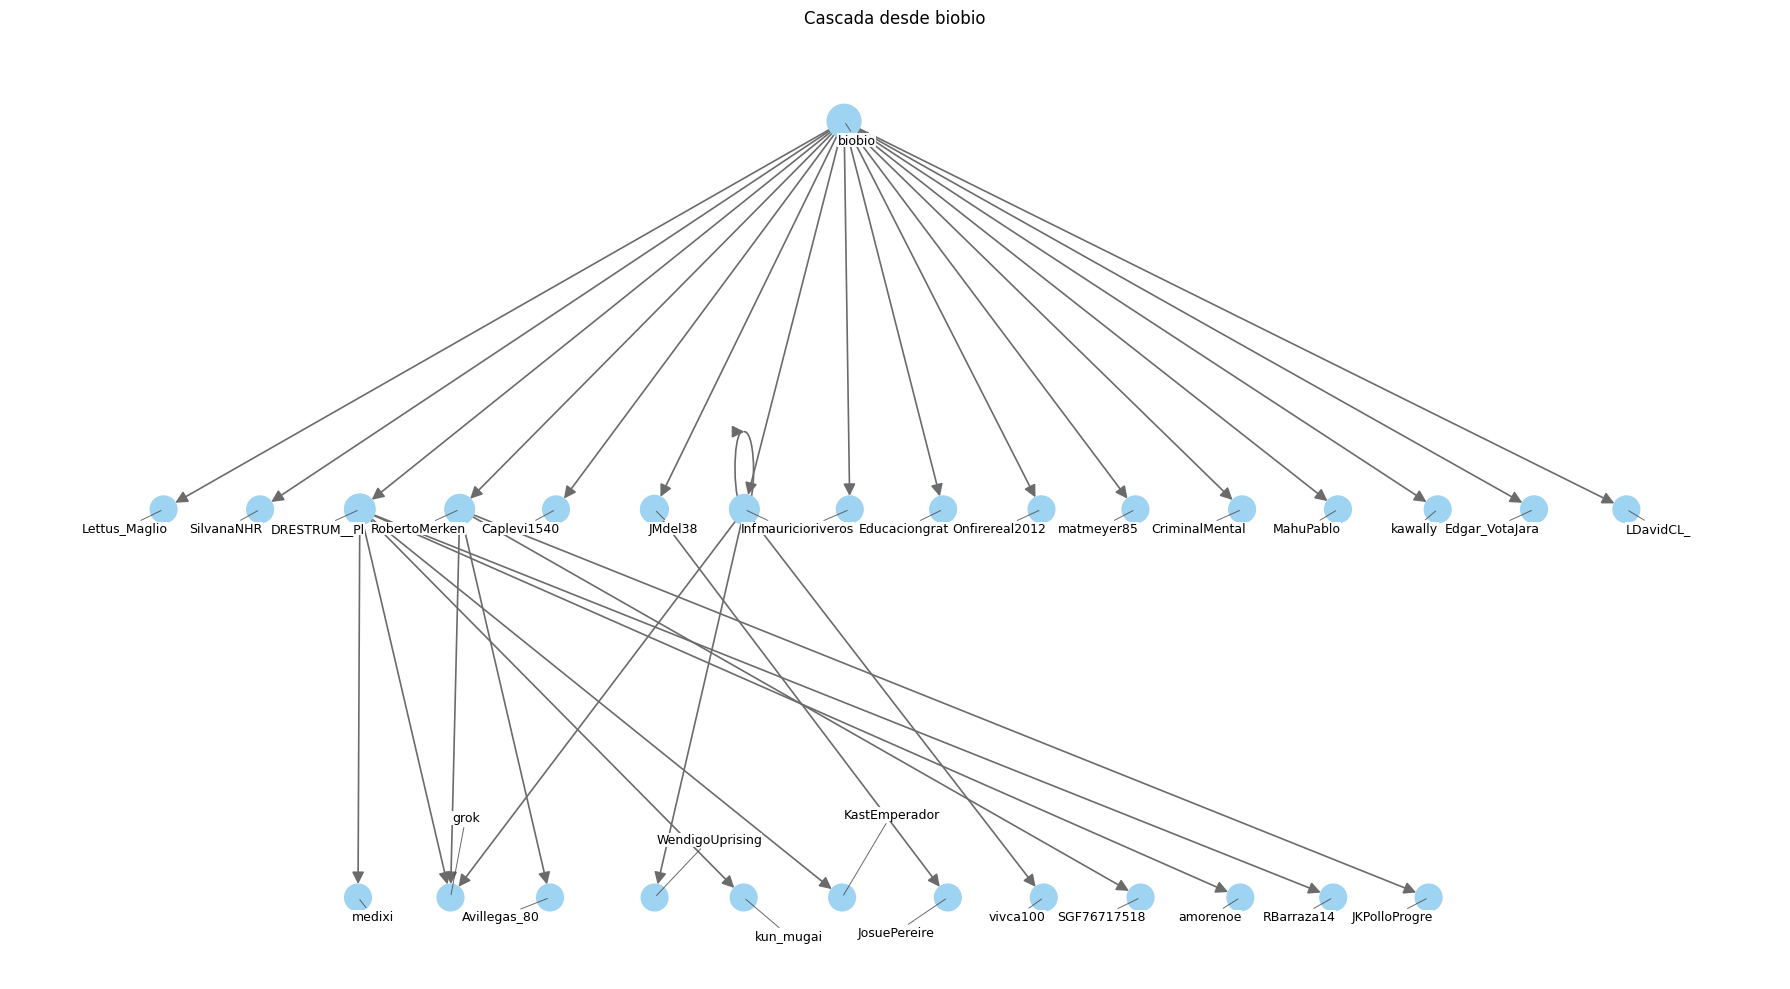

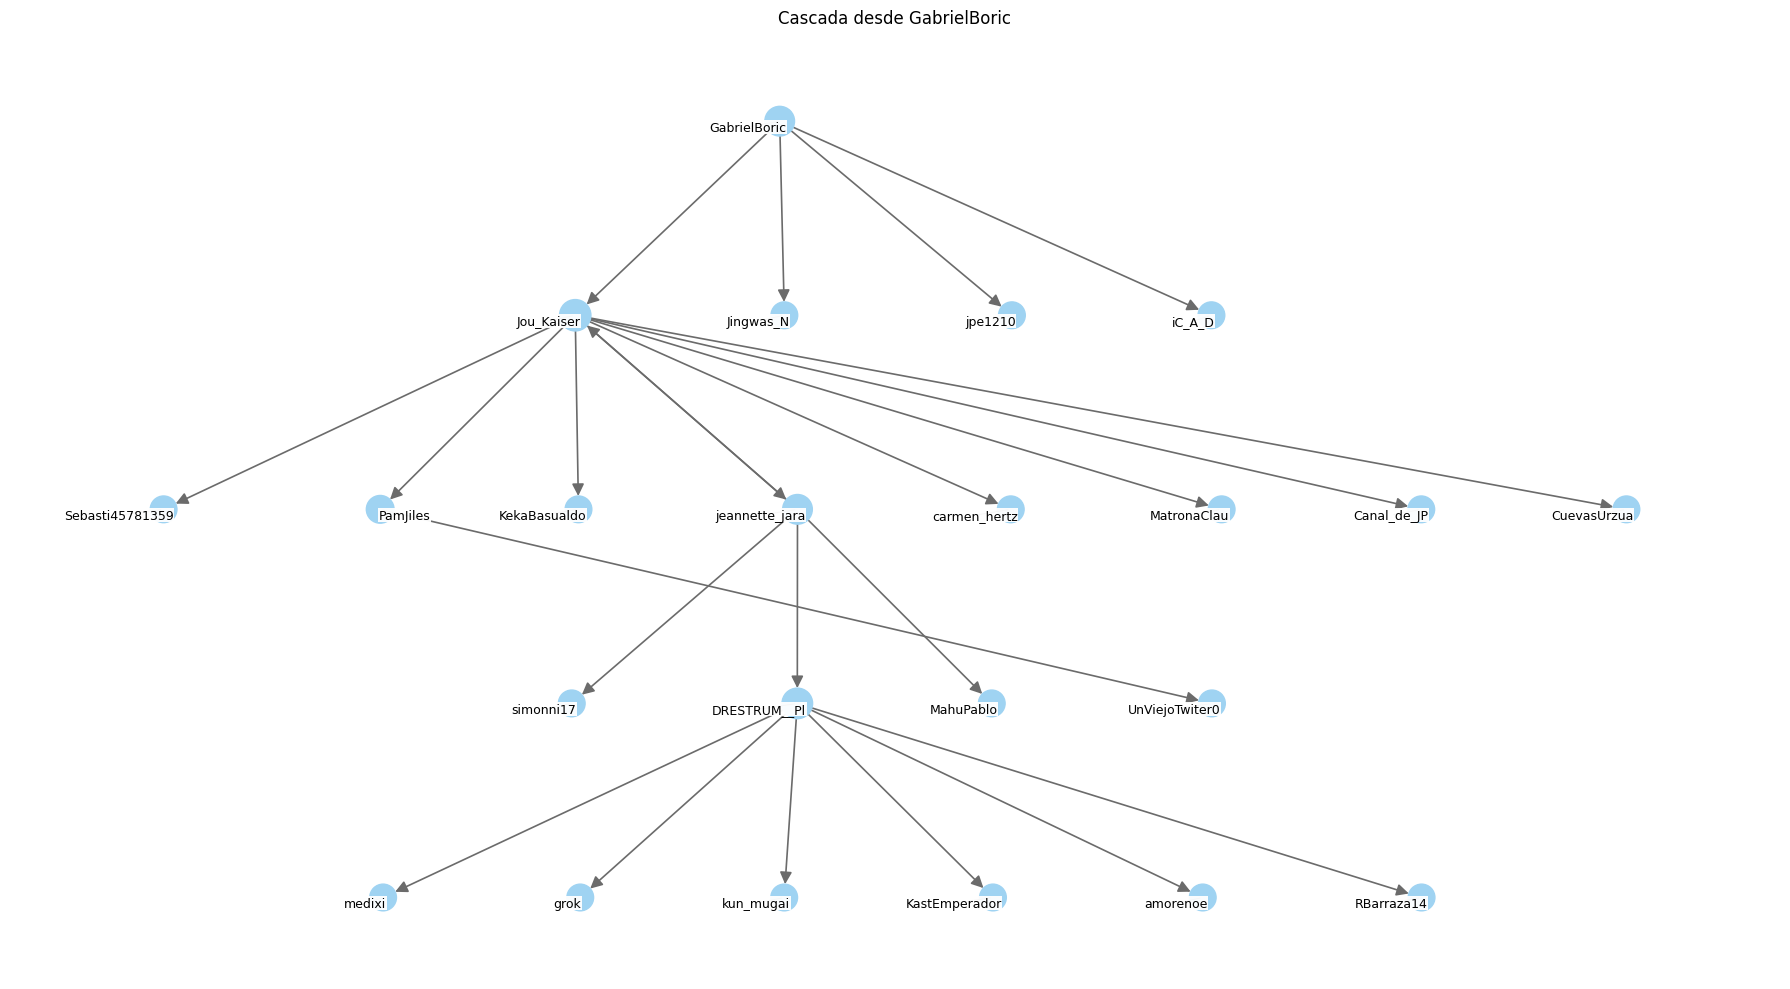

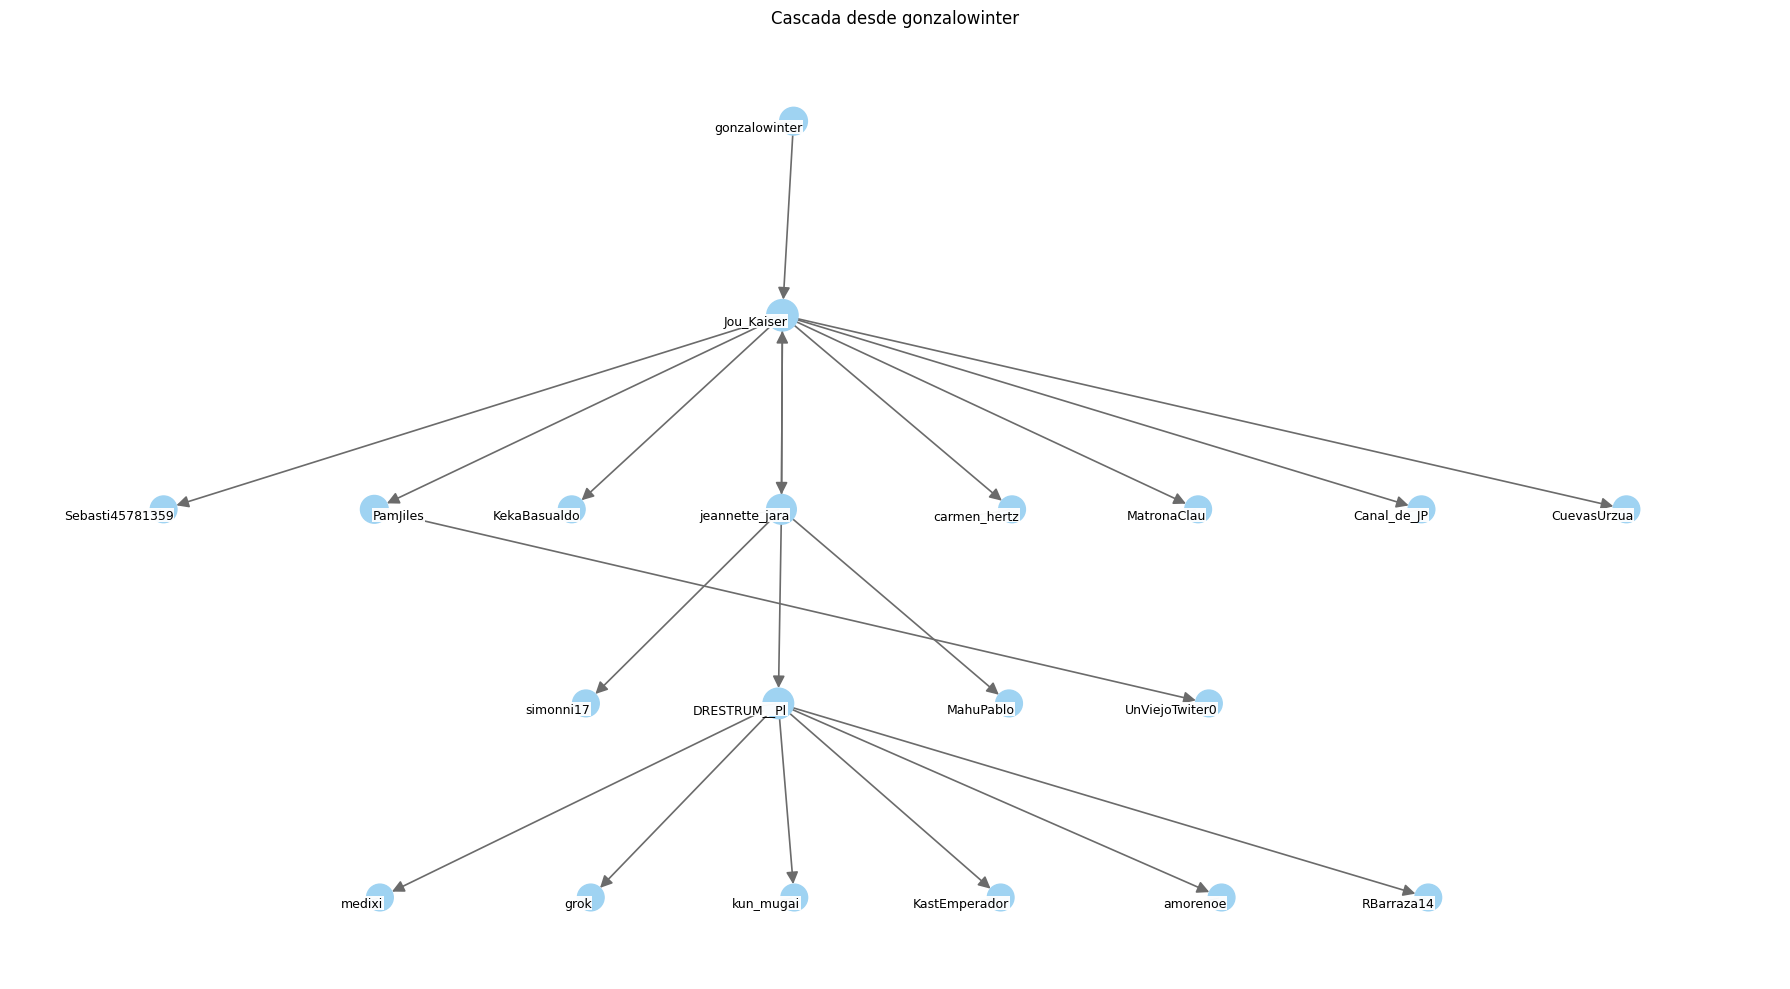

In [ ]:
# =========================
#  Cascadas de replies con labels claros (debajo del nodo)
# =========================

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math, random

# ------------ 1) Grafo: origen ------------
G = nx.DiGraph()
for _, r in data1.iterrows():
    src = r.get('Reply_to_Whom_Handle')
    dst = r.get('Author_Handle')
    if pd.notna(src) and pd.notna(dst):
        src = str(src).strip()
        dst = str(dst).strip()
        if src and dst and src.lower() != 'nan' and dst.lower() != 'nan':
            G.add_edge(src, dst)

# Tiempos por autor (para fallback layout)
author_first_ts = (
    data1.dropna(subset=['Author_Handle','UTC_Time'])
         .assign(UTC_Time=lambda d: pd.to_datetime(d['UTC_Time'], utc=True, errors='coerce'))
         .sort_values('UTC_Time')
         .groupby('Author_Handle')['UTC_Time'].first()
         .to_dict()
)
nx.set_node_attributes(G, author_first_ts, name='time')

# ------------ 2) Raíces ordenadas por tamaño de cascada ------------
def cascade_size(root):
    return 1 + len(nx.descendants(G, root))

roots = [n for n in G.nodes if G.in_degree(n) == 0]
roots = sorted(roots, key=cascade_size, reverse=True)

# ------------ 3) Fallback layout jerárquico ------------
def hierarchical_pos(Gsub, root, level_gap=2.0, x_gap=1.6, jitter=0.10):
    levels = nx.shortest_path_length(Gsub, root)
    buckets = {}
    for n, d in levels.items():
        buckets.setdefault(d, []).append(n)

    def t_key(n):
        t = Gsub.nodes[n].get('time')
        if t is None or pd.isna(t):  # sin tiempo -> al final
            return pd.Timestamp.max.tz_localize('UTC')
        return t

    pos = {}
    for lvl, nodes in sorted(buckets.items()):
        ns = sorted(nodes, key=t_key)
        width = max(1, len(ns)-1)
        xs = [i * x_gap - width * x_gap/2 for i in range(len(ns))]
        for x, n in zip(xs, ns):
            pos[n] = (x + random.uniform(-jitter, jitter), -lvl * level_gap)
    return pos, levels

# ------------ 4) Helpers ------------
def shorten(label, maxlen=22):
    return label if len(label) <= maxlen else (label[:maxlen-1] + "…")

# ------------ 5) Dibujo ------------
def draw_cascade(G, root, min_nodes=8):
    nodes = nx.descendants(G, root) | {root}
    if len(nodes) < min_nodes:
        return

    S = G.subgraph(nodes).copy()

    # Posiciones: intenta Graphviz; si no, fallback
    try:
        from networkx.drawing.nx_agraph import graphviz_layout
        pos = graphviz_layout(S, prog="dot")
        levels = nx.shortest_path_length(S, root)
    except Exception:
        pos, levels = hierarchical_pos(S, root)

    # Tamaño en función del out-degree (influencia local)
    outdeg = dict(S.out_degree())
    sizes = [300 + 70 * math.sqrt(outdeg.get(n,0)+1) for n in S.nodes]

    fig = plt.figure(figsize=(18, 10))
    ax = plt.gca()

    # Nodos y aristas
    nx.draw(
        S, pos,
        with_labels=False, node_size=sizes,
        node_color="#9fd3f2", edge_color="#6b6b6b",
        arrows=True, arrowstyle="-|>", arrowsize=18, width=1.2, ax=ax
    )

    # Labels: SIEMPRE debajo del nodo, centrados, con línea guía
    # dy controla qué tan abajo queda el texto (en coordenadas de datos)
    dy = 0.35
    texts = []
    for n, (x, y) in pos.items():
        label = shorten(n, 24)
        # Línea guía + caja blanca para el texto
        t = ax.annotate(
            label,
            xy=(x, y), xycoords='data',
            xytext=(x, y - dy), textcoords='data',
            ha='center', va='top',
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.95, pad=0.25, edgecolor='none'),
            arrowprops=dict(arrowstyle='-', lw=0.7, color='#444', alpha=0.8),
            zorder=10
        )
        texts.append(t)

    # Separación suave de textos (opcional)
    try:
        from adjustText import adjust_text
        adjust_text(
            texts,
            only_move={'points':'y', 'text':'y'},   # mueve textos solo verticalmente
            expand_points=(1.2, 1.2),
            expand_text=(1.05, 1.05),
            force_text=(0.1, 0.3),
            force_points=(0.2, 0.4),
            lim=150,
            ax=ax
        )
    except Exception:
        pass

    ax.set_title(f"Cascada desde {root}", pad=12)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# ------------ 6) Ejecutar muestra ------------
NUM_CASCADAS = 5   # cuántas raíces graficar
for root in roots[:NUM_CASCADAS]:
    draw_cascade(G, root, min_nodes=8)


Las cascadas muestran patrones distintos de propagación entre fuentes mediáticas y figuras políticas. En los casos de @CNNChile y @biobio, se observa una estructura amplia con muchos nodos conectados directamente a la fuente principal, lo que indica gran alcance pero baja profundidad, la mayoría de las interacciones son respuestas o retuits inmediatos a la publicación original, reflejando un tipo de difusión centralizada y rápida, para medios con alto nivel de visibilidad.

Por otro lado, las cascadas originadas en @evelynmatthei, @GabrielBoric y @gonzalowinter presentan menor amplitud pero mayor ramificación interna, donde ciertos usuarios (por ejemplo, @Jou_Kaiser, @DRESTRUM_PL o @grok) aparecen repetidamente como intermediarios. Esto sugiere una propagación más segmentada donde mensajes se redistribuyen dentro de grupos políticos específicos, generando cadenas más largas de respuestas.

Estas diferencias permiten concluir que los contenidos por sector tienden a generar cascadas más profundas, sostenidas por grupos con afinidad ideológica, mientras que las publicaciones legítimas de medios logran mayor alcance inicial, aunque con menor interacción entre las ramificaciones

### Calculo de métricas

Este bloque realiza el análisis estructural del grafo completo, aplicando métricas de análisis de redes sociales (SNA) para identificar los principales nodos difusores e intermediarios de las conversaciones. Primero, el script construye el grafo dirigido (respuestas y menciones) y calcula medidas como grado, betweenness, closeness, PageRank, eigenvector centrality, k-core y clustering, generando una base cuantitativa para comparar la influencia y el rol de cada cuenta. 

Luego combina algunas de ellas en un “amplifier score”, que pondera difusión (out-degree), intermediación , alcance  e importancia global del grafo (jerarquia), y permite destacar a los actores que más amplifican información, sean humanos, medios o posibles bots.

In [ ]:
# ===========================================
#   MÉTRICAS SNA SOBRE TODO EL DATASET
# ===========================================

import pandas as pd
import networkx as nx
import numpy as np

# ---------------- 1) Construir G con TODO ----------------
G = nx.DiGraph()
for _, r in data1.iterrows():
    src = r.get('Reply_to_Whom_Handle')
    dst = r.get('Author_Handle')
    if pd.notna(src) and pd.notna(dst):
        src = str(src).strip()
        dst = str(dst).strip()
        if src and dst and src.lower() != 'nan' and dst.lower() != 'nan':
            G.add_edge(src, dst)

print(f"Nodos totales: {G.number_of_nodes():,} | Aristas totales: {G.number_of_edges():,}")

#  Eliminar self-loops (respuestas a sí mismo)
self_loops = list(nx.selfloop_edges(G))
if self_loops:
    print(f"Eliminando {len(self_loops)} self-loops...")
    G.remove_edges_from(self_loops)

# ---------------- 2) Métricas base (dirigido) ----------------
deg_total  = dict(G.degree())
deg_in     = dict(G.in_degree())
deg_out    = dict(G.out_degree())

bet = nx.betweenness_centrality(G, normalized=True)
harmonic = nx.harmonic_centrality(G)
pr = nx.pagerank(G, alpha=0.85)

try:
    eig = nx.eigenvector_centrality(G, max_iter=1000)
except nx.PowerIterationFailedConvergence:
    eig = {n: 0.0 for n in G.nodes()}

# ---------------- 3) Métricas adicionales (no dirigido) ----------------
G_u = G.to_undirected(reciprocal=False)
core = nx.core_number(G_u)
clust = nx.clustering(G_u)

# ---------------- 4) DataFrame con TODAS las métricas ----------------
metrics_df = pd.DataFrame({
    'degree': pd.Series(deg_total),
    'in_degree': pd.Series(deg_in),
    'out_degree': pd.Series(deg_out),
    'betweenness': pd.Series(bet),
    'harmonic_closeness': pd.Series(harmonic),
    'pagerank': pd.Series(pr),
    'eigenvector': pd.Series(eig),
    'k_core': pd.Series(core),
    'clustering': pd.Series(clust)
}).fillna(0)

print("Guardando todas las métricas en 'metricas.csv'...")
metrics_df.to_csv('metricas.csv', encoding='utf-8')
print("¡Archivo 'metricas.csv' guardado exitosamente!")

# ---------------- 5) “amplificador de rumores” ----------------
def minmax(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else pd.Series(0, index=s.index)

mm_out = minmax(metrics_df['out_degree'])
mm_bet = minmax(metrics_df['betweenness'])
mm_har = minmax(metrics_df['harmonic_closeness'])
mm_pr  = minmax(metrics_df['pagerank'])

metrics_df['amplifier_score'] = (
    0.35*mm_out + 0.35*mm_bet + 0.15*mm_har + 0.15*mm_pr
)

# ---------------- 6) Resultados: TOP N ----------------
TOP_N = 20
top_amplifiers = metrics_df.sort_values('amplifier_score', ascending=False).head(TOP_N)
top_bridges    = metrics_df.sort_values('betweenness', ascending=False).head(TOP_N)
top_speakers   = metrics_df.sort_values('out_degree', ascending=False).head(TOP_N)
top_hubs       = metrics_df.sort_values('pagerank', ascending=False).head(TOP_N)

display(top_amplifiers.style.set_caption("Top amplificadores (score combinado)"))
display(top_bridges.style.set_caption("Top 'puentes' (betweenness)"))
display(top_speakers.style.set_caption("Top emisores (out-degree)"))
display(top_hubs.style.set_caption("Top hubs estructurales (PageRank)"))


Nodos totales: 631 | Aristas totales: 504
Eliminando 40 self-loops...
Guardando todas las métricas en 'metricas.csv'...
¡Archivo 'metricas.csv' guardado exitosamente!


Los resultados muestran que medios de comunicación como CNNChile y Biobío concentran los mayores valores de out-degree, reflejando gran capacidad de emisión inicial. En cambio, usuarios como Jou_Kaiser y DRESTRUM_PL destacan por su betweenness y amplifier score, actuando como nodos puente entre distintas comunidades y favoreciendo la retransmisión de mensajes.

También aparecen cuentas con alta closeness o PageRank pero bajo out-degree (por ejemplo grok o SilvanaNHR), lo que puede indicar cuentas con conexión a múltiples focos de interacción, automatizadas. En conjunto, estas métricas ayudan a responder las preguntas de la Parte 1 al identificar principales difusores, puentes críticos y patrones de amplificación que diferencian la propagación orgánica de la difusión coordinada o mediática de rumores.

### Visualización dinámica


Este bloque construye la serie diaria de interacciones, aplica un suavizado,
ROLL_DIAS, calcula el acumulado y detecta picos con find_peaks (prominencia) o un fallback por percentil.
Lee peack de actividades frente a un umbral,crecimiento acumulado y estimacion de ritmo de difusion de los twetts. Con esto se comparan los periodos y eventos en peack con sus pendientes inclinadas


#### Visualización temporal

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:97: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  plt.tight_layout()
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:97: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:97: UserWarning: Glyph 127939 (\N{RUNNER}) missing from current font.
  plt.tight_layout()
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages

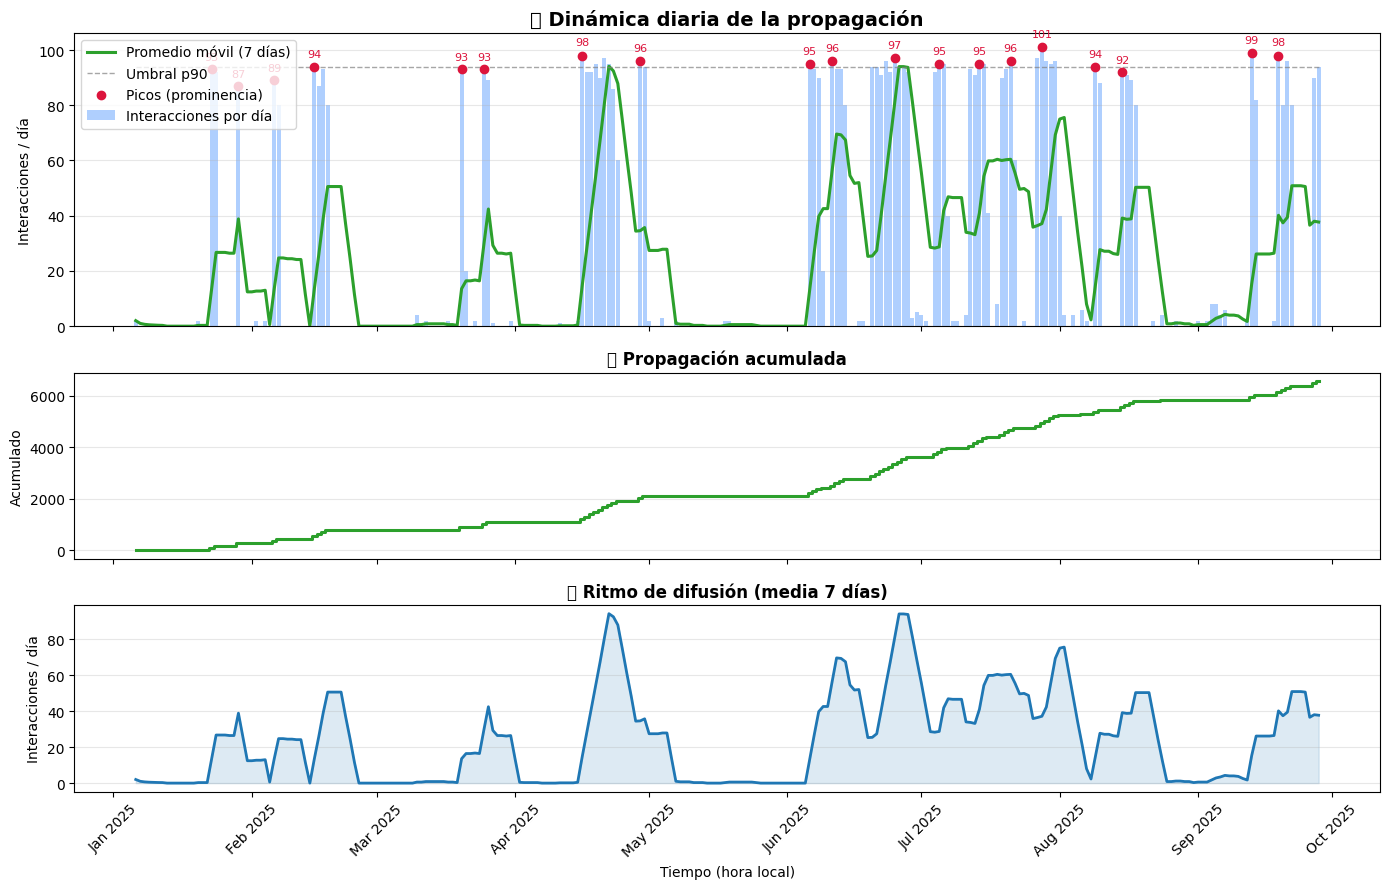

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\756890215.py:118: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\Users\alvar\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


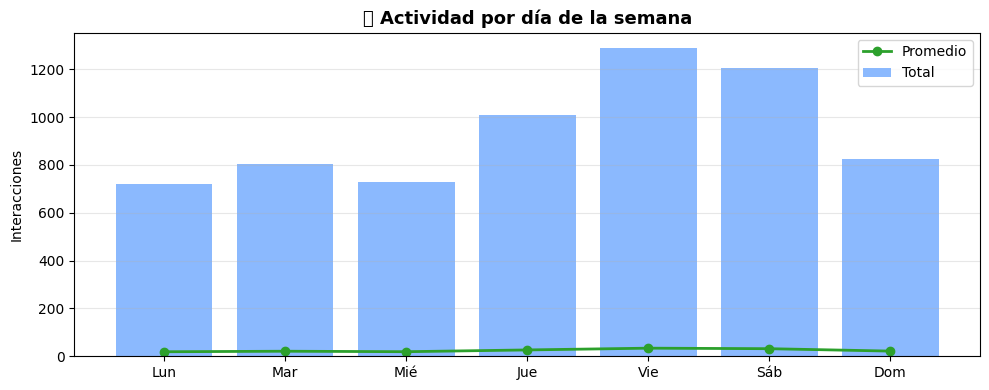

In [ ]:
# ==========================================
#  Timeline DIARIO: claro y sin ambigüedad
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ---------- Config ----------
ROLL_DIAS = 7                 # suavizado
PCT_UMBRAL = 0.90             # línea horizontal de referencia (percentil)
DIST_MIN_PICOS = 3            # distancia mínima entre picos (en días)
USE_LOCAL_TZ = True
LOCAL_TZ = 'America/Santiago'

# ---------- Preparación ----------
df = data1.copy()
df['UTC_Time'] = pd.to_datetime(df['UTC_Time'], utc=True, errors='coerce')
df = df.dropna(subset=['UTC_Time']).sort_values('UTC_Time')

# Serie diaria
ts_day = (df.set_index('UTC_Time')
            .resample('D')
            .size()
            .rename('interacciones'))

if USE_LOCAL_TZ:
    ts_day.index = ts_day.index.tz_convert(LOCAL_TZ)

# Suavizado y acumulado
roll = ts_day.rolling(ROLL_DIAS, min_periods=1).mean()
acum = ts_day.cumsum()

# ---------- Detección de picos (método por prominencia) ----------
#  fallback simple.
peaks_idx = []
try:
    from scipy.signal import find_peaks
    # Umbral de prominencia relativo a la distribución
    prom = np.quantile(ts_day.values, 0.85) * 0.4  # ajuste conservador
    peaks_idx, _ = find_peaks(ts_day.values,
                              distance=DIST_MIN_PICOS,
                              prominence=prom)
except Exception:
    # Fallback: picos por percentil + "máximos locales" básicos
    s = ts_day
    is_peak = (s >= s.quantile(PCT_UMBRAL)) & (s.shift(1) <= s) & (s.shift(-1) <= s)
    peaks_idx = np.where(is_peak.values)[0]

peak_dates = ts_day.index[peaks_idx]
peak_vals  = ts_day.values[peaks_idx]

# Línea de referencia (percentil)
umbral = ts_day.quantile(PCT_UMBRAL)

# ---------- FIGURA: 3 paneles apilados, mismo eje X ----------
fig, (ax1, ax2, ax3) = plt.subplots(
    3, 1, figsize=(14, 9), sharex=True, gridspec_kw={'height_ratios':[2.2,1.4,1.4]}
)

# 1) Conteo diario + suavizado + picos
ax1.bar(ts_day.index, ts_day.values, width=0.9, color='#6ea8fe', alpha=0.55, label='Interacciones por día')
ax1.plot(roll.index, roll.values, color='#2ca02c', lw=2.2, label=f'Promedio móvil ({ROLL_DIAS} días)')
ax1.hlines(umbral, ts_day.index.min(), ts_day.index.max(), colors='gray', linestyles='--',
           linewidth=1, alpha=0.7, label=f'Umbral p{int(PCT_UMBRAL*100)}')

# Marcar picos
ax1.scatter(peak_dates, peak_vals, color='crimson', zorder=3, label='Picos (prominencia)')
for x, y in zip(peak_dates, peak_vals):
    ax1.text(x, y + max(0.03*y, 0.6), f"{int(y)}", ha='center', va='bottom', fontsize=8, color='crimson')

ax1.set_title("📅 Dinámica diaria de la propagación", fontsize=14, weight='bold')
ax1.set_ylabel("Interacciones / día")
ax1.grid(axis='y', alpha=0.3)
ax1.legend(loc='upper left')

# 2) Acumulado (solo línea escalonada)
ax2.step(acum.index, acum.values, where='mid', color='#2ca02c', lw=2.2)
ax2.set_title("📈 Propagación acumulada", fontsize=12, weight='bold')
ax2.set_ylabel("Acumulado")
ax2.grid(axis='y', alpha=0.3)

# 3) Ritmo diario (línea suave, sin eje secundario)
ritmo = ts_day.rolling(ROLL_DIAS, min_periods=1).mean()
ax3.plot(ritmo.index, ritmo.values, color='#1f77b4', lw=2)
ax3.fill_between(ritmo.index, ritmo.values, color='#1f77b4', alpha=0.15)
ax3.set_title(f"🏃 Ritmo de difusión (media {ROLL_DIAS} días)", fontsize=12, weight='bold')
ax3.set_ylabel("Interacciones / día")
ax3.grid(axis='y', alpha=0.3)

# Formato de fechas (común al eje X)
ax3.set_xlabel("Tiempo (hora local)")
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ==========================================================
#  Día de la semana (figura simple y clara)
# ==========================================================
dow_labels = ['Lun','Mar','Mié','Jue','Vie','Sáb','Dom']
dow_num = ts_day.index.dayofweek
df_dow = pd.DataFrame({'dow': dow_num, 'count': ts_day.values})

totales = df_dow.groupby('dow')['count'].sum().reindex(range(7), fill_value=0)
prom = df_dow.groupby('dow')['count'].mean().reindex(range(7), fill_value=0)

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(range(7), totales.values, color='#6ea8fe', alpha=0.8, label='Total')
ax.plot(range(7), prom.values, color='#2ca02c', marker='o', lw=2, label='Promedio')
ax.set_xticks(range(7)); ax.set_xticklabels(dow_labels)
ax.set_title("📊 Actividad por día de la semana", fontsize=13, weight='bold')
ax.set_ylabel("Interacciones")
ax.grid(axis='y', alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()




La segunda figura resume la actividad por día de la semana (total y promedio). Un patrón concentrado en días hábiles/horas pico sugiere consumo Normalizado en cambio, peack en horarios atípicos puede sugerir automatización/coordinación.  Aca se busca mostrar el comportamiento habitual vs un autimatizado.

#### Visualización geografica

Este bloque infere el país de origen de cada cuenta/publicación usando dos señales y con ello su grafico representativo: 
(1) Idioma
(2) El TLD del dominio presente en Author_Web_Page_URL

In [ ]:
# ==========================================
# INFERENCIA DE PAÍS A PARTIR DE IDIOMA Y DOMINIO
# ==========================================
import pandas as pd
import re

df_geo = data1.copy()

# --- 1) Basado en el campo 'Language' ---
lang_to_country = {
    'es': 'Chile/LatAm',  # español genérico
    'en': 'USA/UK',
    'pt': 'Brasil',
    'fr': 'Francia',
    'it': 'Italia',
    'de': 'Alemania',
    'ja': 'Japón',
    'zh': 'China',
    'ar': 'Medio Oriente',
    'tr': 'Turquía',
    'ru': 'Rusia'
}
df_geo['Country_Lang'] = df_geo['Language'].map(lang_to_country)

# --- 2) Basado en dominio de la URL (si existe) ---
def infer_country_from_url(url):
    if pd.isna(url): return None
    url = url.lower()
    # Dominio de nivel superior
    m = re.search(r'\.([a-z]{2})(?:/|$)', url)
    if not m:
        return None
    tld = m.group(1)
    tld_map = {
        'cl': 'Chile', 'ar': 'Argentina', 'mx': 'México', 'co': 'Colombia',
        'pe': 'Perú', 'br': 'Brasil', 'es': 'España', 'us': 'EEUU',
        'uk': 'Reino Unido', 'fr': 'Francia', 'de': 'Alemania',
        'it': 'Italia', 'jp': 'Japón', 'pt': 'Portugal'
    }
    return tld_map.get(tld, None)

df_geo['Country_URL'] = df_geo['Author_Web_Page_URL'].apply(infer_country_from_url)
df_geo['Country_Post'] = df_geo['Post_URL'].apply(infer_country_from_url)

# --- 3) Columna final (prioridad: URL > Language) ---
df_geo['Country_inferred'] = (
    df_geo['Country_URL']
    .combine_first(df_geo['Country_Post'])
    .combine_first(df_geo['Country_Lang'])
)
print(df_geo['Country_inferred'].value_counts().head(10))


Country_inferred
Chile/LatAm    6484
USA/UK           19
Brasil           18
Francia           3
Turquía           1
Name: count, dtype: int64


              Country_world  num_posts
0                    Brazil         18
1                     Chile       6484
2                    France          3
3                    Turkey          1
4  United States of America         19


C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\3903122409.py:30: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


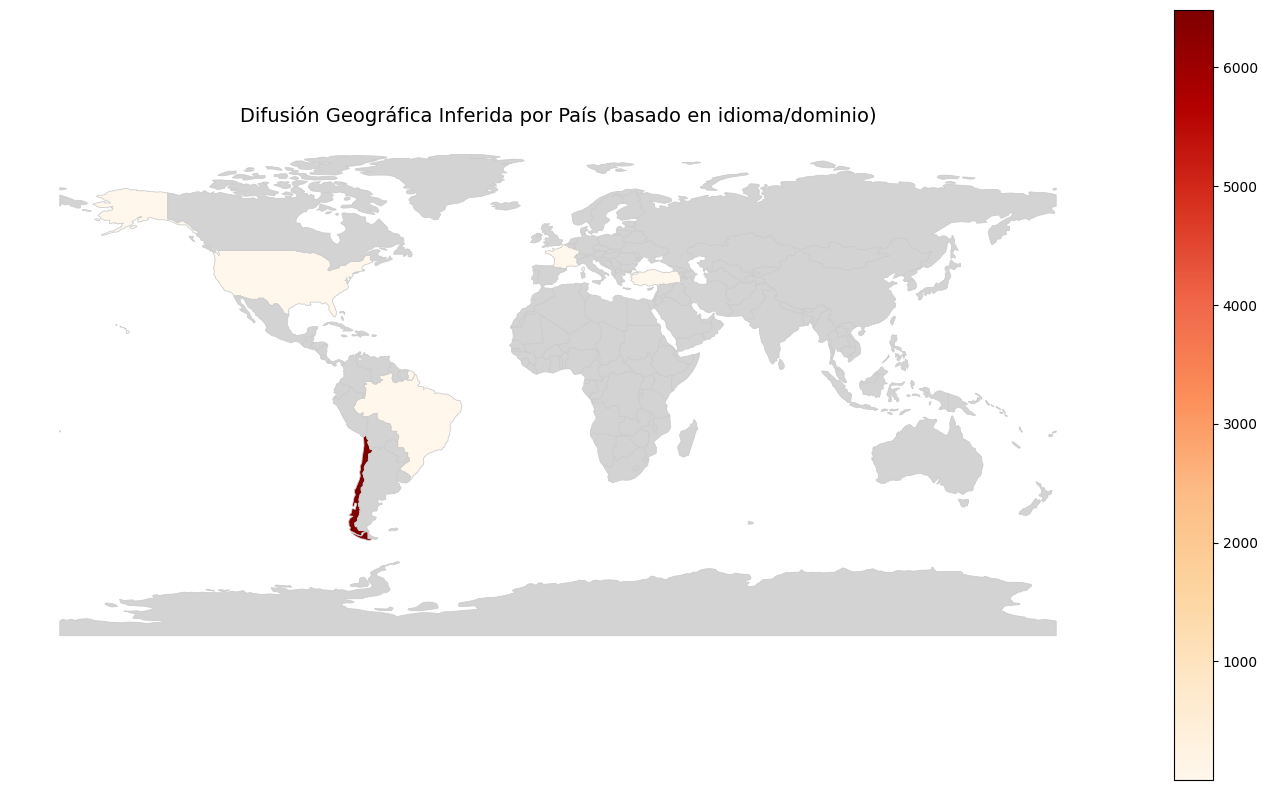

In [59]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# df_geo viene de tu paso anterior:
# df_geo['Country_inferred'] con valores como: Chile/LatAm, USA/UK, Brasil, Francia, Turquía

# 1) Normalizar a los nombres del shapefile (Natural Earth, columna 'name' en inglés)
name_map = {
    'Chile/LatAm': 'Chile',                 # si quieres representar LatAm con Chile
    'USA/UK': 'United States of America',   # usa USA (también podrías dividir a UK si quieres)
    'Brasil': 'Brazil',
    'Francia': 'France',
    'Turquía': 'Turkey',
    # agrega más equivalencias si aparecen
}
df_geo = df_geo.copy()
df_geo['Country_world'] = df_geo['Country_inferred'].map(name_map)

# 2) Agrupar (descarta nulos que no tengan mapeo)
geo_counts = (df_geo
              .dropna(subset=['Country_world'])
              .groupby('Country_world')
              .size()
              .reset_index(name='num_posts'))

print(geo_counts)

# 3) Cargar mapa base y unir
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_merged = world.merge(geo_counts, how='left',
                           left_on='name', right_on='Country_world')

# 4) Plot
fig, ax = plt.subplots(figsize=(14, 8))
world_merged.plot(
    column='num_posts',
    cmap='OrRd',
    linewidth=0.6,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    missing_kwds={'color': 'lightgrey', 'label': 'Sin datos'}
)
plt.title("Difusión Geográfica Inferida por País (basado en idioma/dominio)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()



### Distinguir cuentas automatizadas (mediante patrones)

Este bloque cuantifica la actividad por usuario y visualiza a los 25 autores con más tuits del corpus.Esta salida entrega una vista de concentración, quién emite más mensajes, útil para detectar actores hiperactivos y posibles patrones

✅ Archivo CSV cargado exitosamente.

--- Conteo de Tuits por Usuario ---
Author_Handle
Kasterizador       217
_istlady_          197
RobertoMerken      155
Informa3Chile      147
EncuestasChil10    131
                  ... 
kattym94             1
luiscostabonino      1
Johnenladeep         1
ElTanoOpina          1
Bajarlaalpasto       1
Name: count, Length: 1981, dtype: int64

📝 Conteo completo guardado en 'conteo_tweets_por_usuario.csv'


C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\289234840.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_users.values, y=top_users.index, palette='viridis', orient='h')



📈 Gráfico 'top_usuarios_por_tweets_con_numeros.png' generado exitosamente.


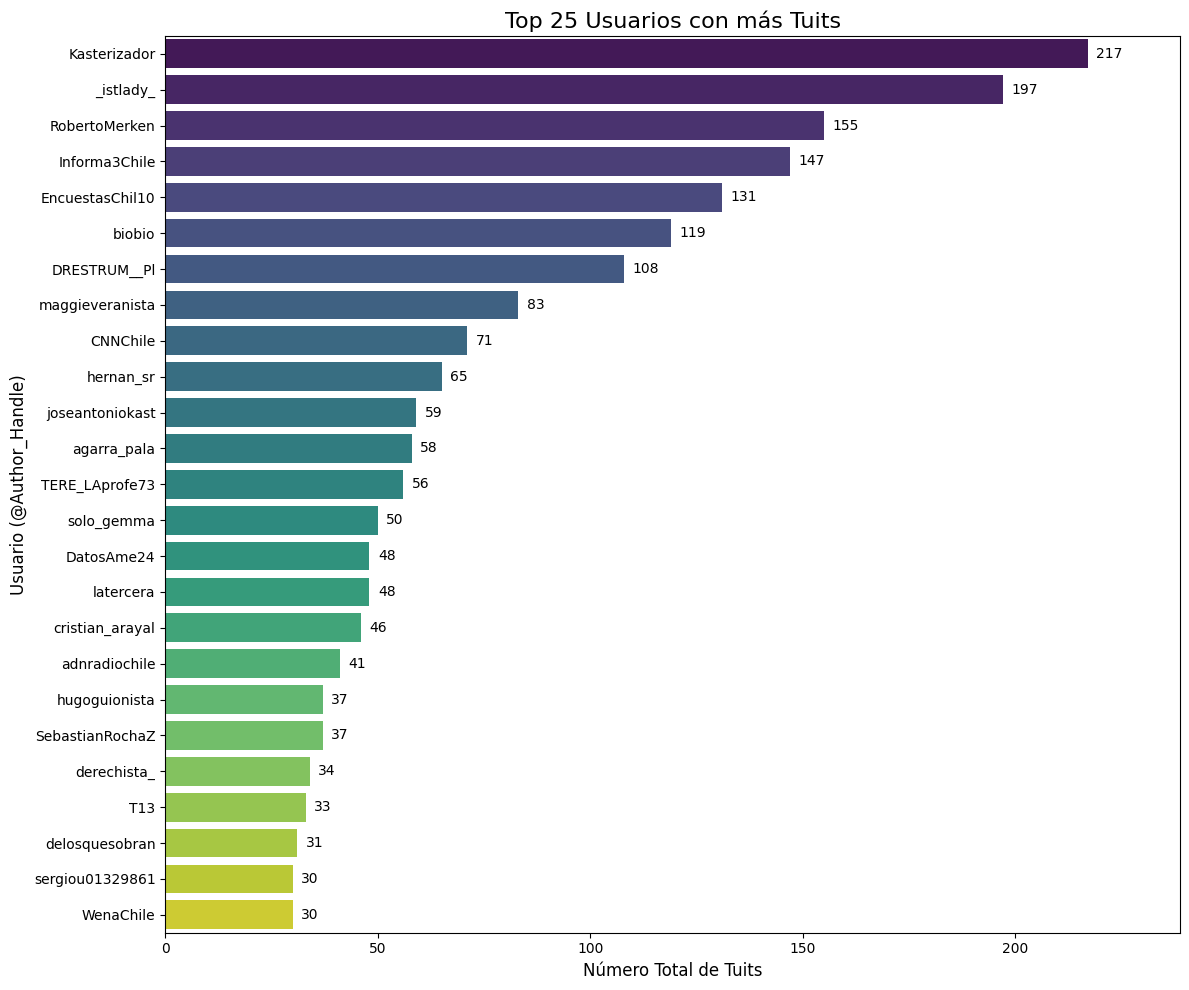

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    # 1. Cargar el dataset
    df = pd.read_csv('../data/Tweets_Elecciones2025_Chile.csv')
    print("✅ Archivo CSV cargado exitosamente.")

    # 2. Calcular el número de tuits por usuario
    user_tweet_counts = df['Author_Handle'].value_counts()
    
    print("\n--- Conteo de Tuits por Usuario ---")
    print(user_tweet_counts)
    
    user_tweet_counts.to_csv('conteo_tweets_por_usuario.csv', header=['tweet_count'])
    print("\n📝 Conteo completo guardado en 'conteo_tweets_por_usuario.csv'")


    # --- 3. Generar un Gráfico Legible con Números por Barra ---
    
    top_n = 25
    top_users = user_tweet_counts.head(top_n)

    plt.figure(figsize=(12, 10))
    
    # El comando barplot ahora se asigna a 'ax' para poder manipular el gráfico
    ax = sns.barplot(x=top_users.values, y=top_users.index, palette='viridis', orient='h')
    
    # --- AÑADIDO: Bucle para agregar el número al final de cada barra ---
    for i in ax.patches:
        # La función ax.text() coloca texto en el gráfico
        # i.get_width() es el largo de la barra (el número de tuits)
        # i.get_y() es la posición 'y' de la barra
        ax.text(i.get_width() + 2,  # Posición x del texto (un poco a la derecha de la barra)
                i.get_y() + i.get_height() / 2, # Posición y del texto (centrado en la barra)
                f'{int(i.get_width())}', # El número a mostrar (como entero)
                ha='left', va='center', # Alineación del texto
                fontsize=10, color='black')
    
    # Ajustar el límite del eje X para dar espacio a los números
    ax.set_xlim(right=top_users.values.max() * 1.1)

    plt.title(f'Top {top_n} Usuarios con más Tuits', fontsize=16)
    plt.xlabel('Número Total de Tuits', fontsize=12)
    plt.ylabel('Usuario (@Author_Handle)', fontsize=12)
    
    plt.tight_layout()
    
    graph_filename = 'top_usuarios_por_tweets_con_numeros.png'
    plt.savefig(graph_filename)
    print(f"\n📈 Gráfico '{graph_filename}' generado exitosamente.")


except FileNotFoundError:
    print("⚠️ Error: El archivo 'Tweets_Elecciones2025_Chile.csv' no se encontró.")
    print("Por favor, asegúrate de que el archivo CSV está en el mismo directorio que el script.")
except KeyError as e:
    print(f"⚠️ Error de Clave: No se encontró la columna {e} en el archivo.")
    print("Por favor, verifica que los nombres de las columnas en tu CSV sean correctos.")
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")

El gráfico apoya las preguntas de la Parte 1 al evidenciar quiénes generan el mayor volumen de contenido y, por tanto, pueden marcar el ritmo inicial de propagación de contenido. Los primeros puestos combinan medios tradicionales (difusión legítima) y cuentas con comportamiento repetitivo, posibles amplificadores o bots.


Umbrales
- Bot Score 0-20: "Humano"
- Bot Score 21-50: "Sospechoso"
- Bot Score 51-100: "Bot_Probable"

Este bloque estima la probabilidad de automatización por cuenta en:

 temporalidad (tweets/hora, regularidad de intervalos y su CV, repetición de intervalos “exactos”) 
 
 contenido (duplicación de textos, prefijos repetidos, uniformidad de longitudes), 
 
 tipo de actividad (ratio de retweets, “solo retweets”), de engagement (bajo E/V), 
 
 patrón horario (actividad de madrugada). 

Con todas ellas arma un Indicadores_Bot y lo normaliza a Bot_Score (0–100), que luego clasifica en Humano / Sospechoso / Bot_Probable.

Analizando patrones de comportamiento...
Total de tweets: 6572
Total de usuarios: 1981

ANÁLISIS AVANZADO DE DETECCIÓN DE BOTS

Usuarios analizados: 408

Distribución de clasificación:
Clasificacion
Humano          305
Sospechoso       73
Bot_Probable     30
Name: count, dtype: int64

Estadísticas del Bot Score:
count    408.000000
mean      15.686275
std       23.355381
min        0.000000
25%        0.000000
50%        0.000000
75%       40.000000
max      100.000000
Name: Bot_Score, dtype: float64

TOP 20 CUENTAS CON MAYOR PROBABILIDAD DE SER BOTS
  Author_Handle  Total_Tweets  Bot_Score  Indicadores_Bot  Tweets_Per_Hour  Ratio_Retweets  Solo_Retweets  Ratio_Duplicacion_Contenido  CV_Intervalos Clasificacion
      lobofacho             8      100.0                5             0.00               0          False                        0.000          1.279  Bot_Probable
Chileno17039890            11      100.0                5             0.00               0          False          

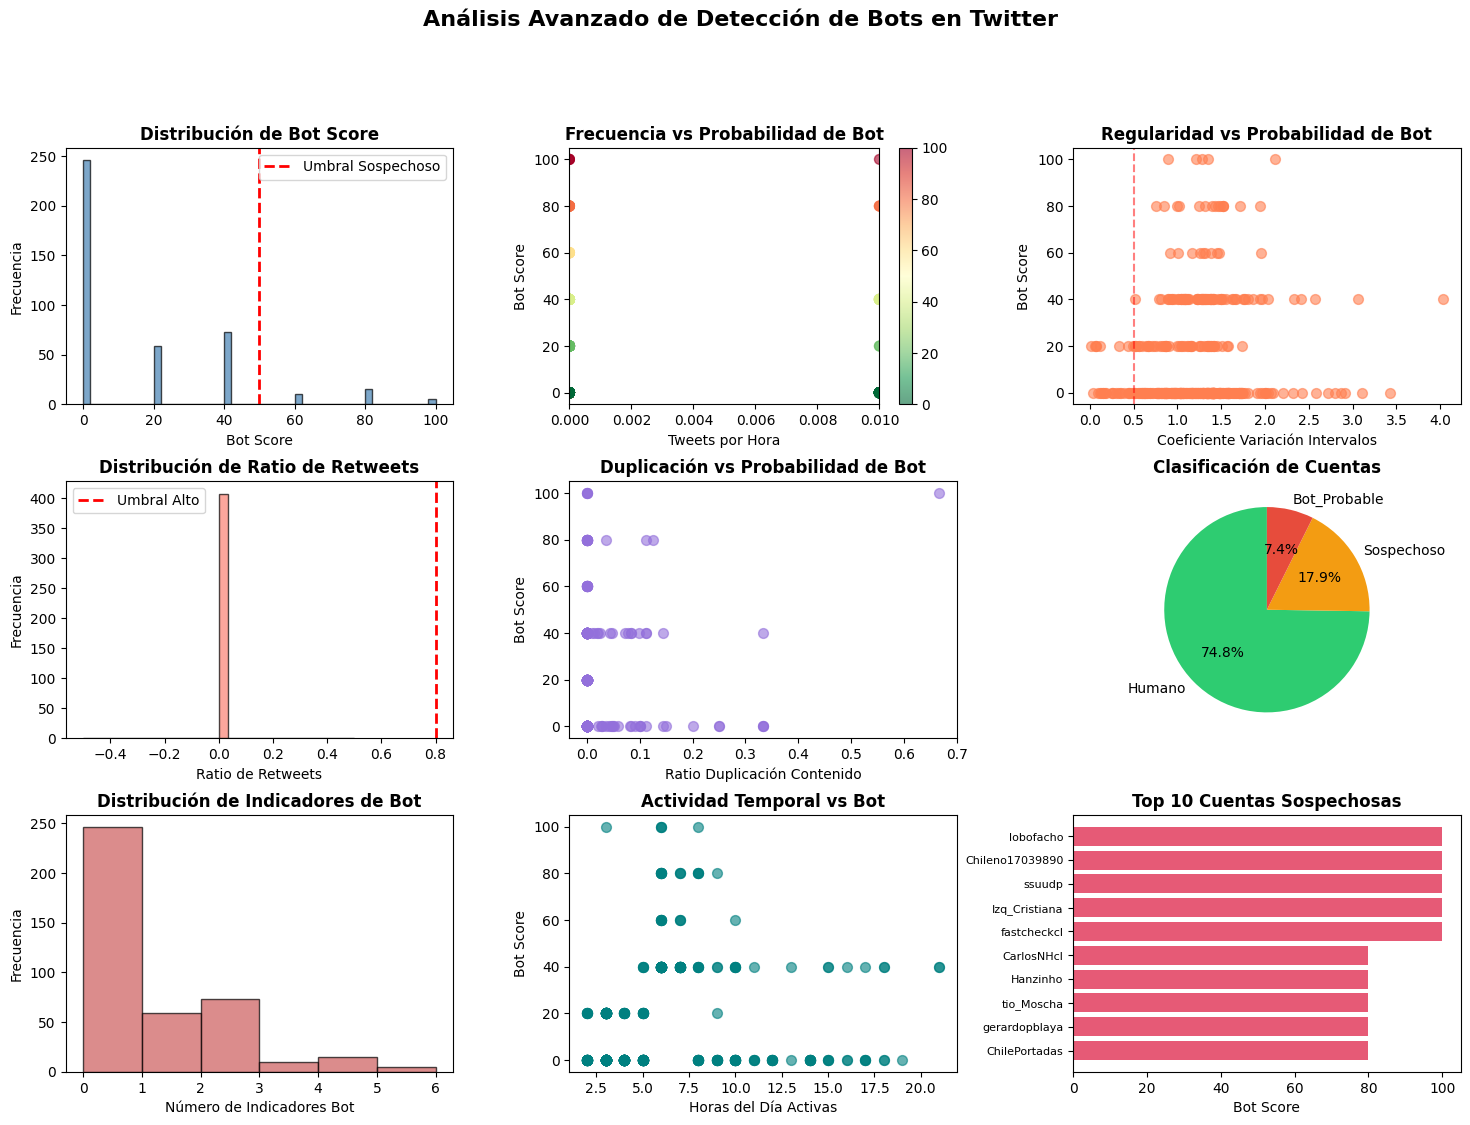

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from scipy import stats

data1 = pd.read_csv('../data/Tweets_Elecciones2025_Chile.csv')

# Convertir fecha a datetime
data1['UTC_Time'] = pd.to_datetime(data1['UTC_Time'])
data1['hora'] = data1['UTC_Time'].dt.hour
data1['minuto'] = data1['UTC_Time'].dt.minute
data1['dia_semana'] = data1['UTC_Time'].dt.dayofweek

print("Analizando patrones de comportamiento...")
print(f"Total de tweets: {len(data1)}")
print(f"Total de usuarios: {data1['Author_Handle'].nunique()}")


def analisis_avanzado_comportamiento(df):
    """
    Análisis más sensible basado en investigación de detección de bots
    """
    resultados = []
    
    for author in df['Author_Handle'].unique():
        user_data = df[df['Author_Handle'] == author].copy()
        user_data = user_data.sort_values('UTC_Time')
        
        n_tweets = len(user_data)
        
        # Filtrar usuarios con actividad mínima
        if n_tweets < 3:
            continue
        
        # === ANÁLISIS TEMPORAL ===
        tiempo_total = (user_data['UTC_Time'].max() - user_data['UTC_Time'].min()).total_seconds() / 3600
        tweets_per_hour = n_tweets / tiempo_total if tiempo_total > 0 else 0
        
        # Intervalos entre tweets
        intervalos = user_data['UTC_Time'].diff().dt.total_seconds().dropna()
        
        if len(intervalos) > 0:
            mean_intervalo = intervalos.mean()
            std_intervalo = intervalos.std()
            cv_intervalo = std_intervalo / mean_intervalo if mean_intervalo > 0 else 0
            
            # Detectar patrones exactos (segundos exactos)
            intervalos_segundos = intervalos.round(0)
            intervalos_unicos = len(intervalos_segundos.unique())
            ratio_intervalos_repetidos = 1 - (intervalos_unicos / len(intervalos_segundos))
            
            # Intervalos sospechosamente regulares (ej: cada 60s, 120s, 300s)
            intervalos_comunes = intervalos_segundos.mode()[0] if len(intervalos_segundos) > 0 else 0
            frecuencia_intervalo_comun = (intervalos_segundos == intervalos_comunes).sum() / len(intervalos_segundos)
        else:
            cv_intervalo = 0
            ratio_intervalos_repetidos = 0
            frecuencia_intervalo_comun = 0
            intervalos_comunes = 0
        
        # === ANÁLISIS DE CONTENIDO ===
        # Tweets idénticos
        tweets_unicos = user_data['Tweet_Content'].nunique()
        ratio_duplicacion = 1 - (tweets_unicos / n_tweets)
        
        # Longitud de tweets
        longitudes = user_data['Tweet_Content'].str.len()
        mean_longitud = longitudes.mean()
        std_longitud = longitudes.std()
        cv_longitud = std_longitud / mean_longitud if mean_longitud > 0 else 0
        
        # Detectar tweets muy similares (primeras 50 caracteres)
        prefijos = user_data['Tweet_Content'].str[:50]
        prefijos_unicos = prefijos.nunique()
        ratio_prefijos_repetidos = 1 - (prefijos_unicos / n_tweets)
        
        # === ANÁLISIS DE TIPO DE ACTIVIDAD ===
        type_counts = user_data['Type'].value_counts(normalize=True)
        ratio_retweets = type_counts.get('retweet', 0) if isinstance(type_counts.index[0], str) else 0
        ratio_replies = type_counts.get('reply', 0) if isinstance(type_counts.index[0], str) else 0
        ratio_quotes = type_counts.get('quote', 0) if isinstance(type_counts.index[0], str) else 0
        
        # Bot de amplificación: solo retweets
        solo_retweets = ratio_retweets > 0.95
        
        # === ANÁLISIS DE ENGAGEMENT ===
        engagement_total = (
            user_data['Reply_Count'].fillna(0) + 
            user_data['Repost_Count'].fillna(0) + 
            user_data['Like_Count'].fillna(0)
        )
        engagement_promedio = engagement_total.mean()
        engagement_mediana = engagement_total.median()
        
        # Ratio engagement/followers (aproximado por views)
        views_promedio = user_data['View_Count'].fillna(0).mean()
        ratio_engagement_views = engagement_promedio / views_promedio if views_promedio > 0 else 0
        
        # === ANÁLISIS DE PATRONES HORARIOS ===
        horas_activas = user_data['hora'].nunique()
        
        # Distribución horaria (entropía)
        distribucion_horas = user_data['hora'].value_counts(normalize=True)
        entropia_horas = stats.entropy(distribucion_horas) if len(distribucion_horas) > 1 else 0
        
        # Actividad en horas atípicas (madrugada: 2-6 AM)
        tweets_madrugada = user_data[user_data['hora'].between(2, 6)].shape[0]
        ratio_madrugada = tweets_madrugada / n_tweets
        
        # === ANÁLISIS DE FUENTE/ORIGEN ===
        # Detectar si todos los tweets son desde misma fuente
        sources = user_data.get('Source', pd.Series([None]*len(user_data)))
        sources_unicos = sources.nunique()
        
        # === INDICADORES DE BOT ===
        indicadores_bot = 0
        
        # 1. Alta frecuencia (>3 tweets/hora)
        if tweets_per_hour > 3:
            indicadores_bot += 2
        if tweets_per_hour > 10:
            indicadores_bot += 3
            
        # 2. Intervalos muy regulares (CV < 0.5)
        if cv_intervalo < 0.5 and n_tweets > 5:
            indicadores_bot += 3
            
        # 3. Muchos intervalos repetidos
        if ratio_intervalos_repetidos > 0.5:
            indicadores_bot += 2
            
        # 4. Intervalo común muy frecuente (>60% tweets con mismo intervalo)
        if frecuencia_intervalo_comun > 0.6:
            indicadores_bot += 3
            
        # 5. Alto ratio de contenido duplicado
        if ratio_duplicacion > 0.5:
            indicadores_bot += 3
            
        # 6. Prefijos muy repetidos (copy-paste)
        if ratio_prefijos_repetidos > 0.6:
            indicadores_bot += 2
            
        # 7. Solo retweets
        if solo_retweets:
            indicadores_bot += 4
            
        # 8. Muy alto ratio de retweets (>80%)
        if ratio_retweets > 0.8:
            indicadores_bot += 2
            
        # 9. Actividad 24/7
        if horas_activas > 20:
            indicadores_bot += 2
            
        # 10. Baja entropía horaria (siempre a las mismas horas)
        if entropia_horas < 2.0 and horas_activas > 5:
            indicadores_bot += 2
            
        # 11. Mucha actividad en madrugada
        if ratio_madrugada > 0.3:
            indicadores_bot += 1
            
        # 12. Bajo engagement
        if engagement_promedio < 1 and n_tweets > 10:
            indicadores_bot += 1
            
        # 13. Longitud muy uniforme
        if cv_longitud < 0.2 and n_tweets > 5:
            indicadores_bot += 2
        
        resultados.append({
            'Author_Handle': author,
            'Author_Name': user_data['Author_Name'].iloc[0],
            'Total_Tweets': n_tweets,
            'Tweets_Per_Hour': round(tweets_per_hour, 2),
            'CV_Intervalos': round(cv_intervalo, 3),
            'Ratio_Intervalos_Repetidos': round(ratio_intervalos_repetidos, 3),
            'Frecuencia_Intervalo_Comun': round(frecuencia_intervalo_comun, 3),
            'Intervalo_Comun_Segundos': intervalos_comunes,
            'Ratio_Duplicacion_Contenido': round(ratio_duplicacion, 3),
            'Ratio_Prefijos_Repetidos': round(ratio_prefijos_repetidos, 3),
            'Ratio_Retweets': round(ratio_retweets, 3),
            'Solo_Retweets': solo_retweets,
            'Horas_Activas': horas_activas,
            'Entropia_Horaria': round(entropia_horas, 3),
            'Ratio_Actividad_Madrugada': round(ratio_madrugada, 3),
            'Engagement_Promedio': round(engagement_promedio, 2),
            'CV_Longitud': round(cv_longitud, 3),
            'Indicadores_Bot': indicadores_bot,
            'Verified': user_data['Verified_Status'].iloc[0] if 'Verified_Status' in user_data.columns else False
        })
    
    return pd.DataFrame(resultados)

# Ejecutar análisis
metricas = analisis_avanzado_comportamiento(data1)

# Calcular Bot Score normalizado (0-100)
max_indicadores = metricas['Indicadores_Bot'].max()
if max_indicadores > 0:
    metricas['Bot_Score'] = (metricas['Indicadores_Bot'] / max_indicadores * 100).round(1)
else:
    metricas['Bot_Score'] = 0

# Clasificación más estricta
metricas['Clasificacion'] = pd.cut(
    metricas['Bot_Score'],
    bins=[-1, 20, 50, 100],
    labels=['Humano', 'Sospechoso', 'Bot_Probable']
)

# Ordenar por score
metricas = metricas.sort_values('Bot_Score', ascending=False)

# Guardar resultados
metricas.to_csv('../data/analisis_bots_mejorado.csv', index=False)

# REPORTES
print("\n" + "="*80)
print("ANÁLISIS AVANZADO DE DETECCIÓN DE BOTS")
print("="*80)

print(f"\nUsuarios analizados: {len(metricas)}")
print(f"\nDistribución de clasificación:")
print(metricas['Clasificacion'].value_counts())
print(f"\nEstadísticas del Bot Score:")
print(metricas['Bot_Score'].describe())

print("\n" + "="*80)
print("TOP 20 CUENTAS CON MAYOR PROBABILIDAD DE SER BOTS")
print("="*80)
top_bots = metricas.head(20)[[
    'Author_Handle', 'Total_Tweets', 'Bot_Score', 'Indicadores_Bot',
    'Tweets_Per_Hour', 'Ratio_Retweets', 'Solo_Retweets',
    'Ratio_Duplicacion_Contenido', 'CV_Intervalos', 'Clasificacion'
]]
print(top_bots.to_string(index=False))

# Análisis de patrones específicos
print("\n" + "="*80)
print("PATRONES SOSPECHOSOS DETECTADOS")
print("="*80)

# Cuentas con intervalos muy regulares
regulares = metricas[(metricas['CV_Intervalos'] < 0.5) & (metricas['Total_Tweets'] > 10)]
print(f"\n1. Cuentas con intervalos muy regulares: {len(regulares)}")
if len(regulares) > 0:
    print(regulares.head(5)[['Author_Handle', 'CV_Intervalos', 'Frecuencia_Intervalo_Comun', 'Bot_Score']])

# Cuentas solo retweets
solo_rt = metricas[metricas['Solo_Retweets'] == True]
print(f"\n2. Cuentas que SOLO hacen retweets: {len(solo_rt)}")
if len(solo_rt) > 0:
    print(solo_rt.head(5)[['Author_Handle', 'Total_Tweets', 'Ratio_Retweets', 'Bot_Score']])

# Contenido muy duplicado
duplicados = metricas[metricas['Ratio_Duplicacion_Contenido'] > 0.7]
print(f"\n3. Cuentas con contenido muy duplicado: {len(duplicados)}")
if len(duplicados) > 0:
    print(duplicados.head(5)[['Author_Handle', 'Ratio_Duplicacion_Contenido', 'Ratio_Prefijos_Repetidos', 'Bot_Score']])

# Alta frecuencia
alta_freq = metricas[metricas['Tweets_Per_Hour'] > 5]
print(f"\n4. Cuentas con alta frecuencia (>5 tweets/hora): {len(alta_freq)}")
if len(alta_freq) > 0:
    print(alta_freq.head(5)[['Author_Handle', 'Tweets_Per_Hour', 'Total_Tweets', 'Bot_Score']])

# Visualizaciones mejoradas
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Distribución Bot Score
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(metricas['Bot_Score'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(50, color='red', linestyle='--', linewidth=2, label='Umbral Sospechoso')
ax1.set_xlabel('Bot Score', fontsize=10)
ax1.set_ylabel('Frecuencia', fontsize=10)
ax1.set_title('Distribución de Bot Score', fontsize=12, fontweight='bold')
ax1.legend()

# 2. Tweets/hora vs Bot Score
ax2 = fig.add_subplot(gs[0, 1])
scatter = ax2.scatter(metricas['Tweets_Per_Hour'], metricas['Bot_Score'], 
                     c=metricas['Bot_Score'], cmap='RdYlGn_r', alpha=0.6, s=50)
ax2.set_xlabel('Tweets por Hora', fontsize=10)
ax2.set_ylabel('Bot Score', fontsize=10)
ax2.set_title('Frecuencia vs Probabilidad de Bot', fontsize=12, fontweight='bold')
ax2.set_xlim(0, min(metricas['Tweets_Per_Hour'].quantile(0.95), metricas['Tweets_Per_Hour'].max()))
plt.colorbar(scatter, ax=ax2)

# 3. CV Intervalos vs Bot Score
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(metricas['CV_Intervalos'], metricas['Bot_Score'], alpha=0.6, s=50, color='coral')
ax3.set_xlabel('Coeficiente Variación Intervalos', fontsize=10)
ax3.set_ylabel('Bot Score', fontsize=10)
ax3.set_title('Regularidad vs Probabilidad de Bot', fontsize=12, fontweight='bold')
ax3.axvline(0.5, color='red', linestyle='--', alpha=0.5)

# 4. Ratio Retweets
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(metricas['Ratio_Retweets'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
ax4.axvline(0.8, color='red', linestyle='--', linewidth=2, label='Umbral Alto')
ax4.set_xlabel('Ratio de Retweets', fontsize=10)
ax4.set_ylabel('Frecuencia', fontsize=10)
ax4.set_title('Distribución de Ratio de Retweets', fontsize=12, fontweight='bold')
ax4.legend()

# 5. Duplicación de contenido
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(metricas['Ratio_Duplicacion_Contenido'], metricas['Bot_Score'], 
           alpha=0.6, s=50, color='mediumpurple')
ax5.set_xlabel('Ratio Duplicación Contenido', fontsize=10)
ax5.set_ylabel('Bot Score', fontsize=10)
ax5.set_title('Duplicación vs Probabilidad de Bot', fontsize=12, fontweight='bold')

# 6. Clasificación
ax6 = fig.add_subplot(gs[1, 2])
clasificacion_counts = metricas['Clasificacion'].value_counts()
colors = ['#2ecc71', '#f39c12', '#e74c3c']
ax6.pie(clasificacion_counts, labels=clasificacion_counts.index, autopct='%1.1f%%', 
       startangle=90, colors=colors[:len(clasificacion_counts)])
ax6.set_title('Clasificación de Cuentas', fontsize=12, fontweight='bold')

# 7. Indicadores de bot
ax7 = fig.add_subplot(gs[2, 0])
ax7.hist(metricas['Indicadores_Bot'], bins=range(0, int(metricas['Indicadores_Bot'].max())+2), 
        edgecolor='black', alpha=0.7, color='indianred')
ax7.set_xlabel('Número de Indicadores Bot', fontsize=10)
ax7.set_ylabel('Frecuencia', fontsize=10)
ax7.set_title('Distribución de Indicadores de Bot', fontsize=12, fontweight='bold')

# 8. Actividad temporal
ax8 = fig.add_subplot(gs[2, 1])
ax8.scatter(metricas['Horas_Activas'], metricas['Bot_Score'], alpha=0.6, s=50, color='teal')
ax8.set_xlabel('Horas del Día Activas', fontsize=10)
ax8.set_ylabel('Bot Score', fontsize=10)
ax8.set_title('Actividad Temporal vs Bot', fontsize=12, fontweight='bold')

# 9. Top 10 bots
ax9 = fig.add_subplot(gs[2, 2])
top10 = metricas.head(10)
ax9.barh(range(len(top10)), top10['Bot_Score'], color='crimson', alpha=0.7)
ax9.set_yticks(range(len(top10)))
ax9.set_yticklabels([h[:15] + '...' if len(h) > 15 else h for h in top10['Author_Handle']], fontsize=8)
ax9.set_xlabel('Bot Score', fontsize=10)
ax9.set_title('Top 10 Cuentas Sospechosas', fontsize=12, fontweight='bold')
ax9.invert_yaxis()

plt.suptitle('Análisis Avanzado de Detección de Bots en Twitter', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('../data/analisis_bots_mejorado.png', dpi=300, bbox_inches='tight')
print(f"\n✓ Visualización guardada: ../data/analisis_bots_mejorado.png")
print(f"✓ Resultados guardados: ../data/analisis_bots_mejorado.csv")

plt.show()

El modelo clasifica 305 (≈74.8%) como humanos, 73 (≈17.9%) sospechosos y 30 (≈7.4%) como bot probables. Llama la atención que no hay cuentas con >5 tweets/hora, por lo que las detecciones se apoyan más en regularidad temporal, alto ratio de retweets/solo RT, duplicación de contenido y baja entropía horaria. 

## Parte 2

Este bloque prepara el análisis de la Parte 2. Limpia y tokeniza los tuits en español, genera unigramas y bigramas, y construye una lista de “temas posibles” (5 apariciones). Luego marca tuits con contexto de desinformación mediante un conjunto de palabras y cuenta qué términos/n-gramas aparecen más en esos contextos. El resultado identifica caracteristica en los hilos de desinformación y ayuda a responder: ¿qué términos/narrativas destacan y qué sesgos reflejan? (por ejemplo, cuando atacan a un candidato, enfatizan miedo/escándalo o usan léxico y jergas).

### Construcción de grafo

In [102]:
import re
import pandas as pd
from collections import Counter
from itertools import chain
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams

# Asegúrate de tener las stopwords en español
nltk.download('stopwords')
stops = set(stopwords.words('spanish')) | {'https', 'rt', 'www', 'com', 'tco'}

# 1️⃣ Extraer texto limpio
data1['clean_text'] = data1['Tweet_Content'].str.lower().apply(
    lambda x: re.sub(r'[^a-záéíóúñü0-9\s]', '', str(x))
)

# 2️⃣ Tokenizar y eliminar stopwords
data1['tokens'] = data1['clean_text'].apply(
    lambda x: [w for w in x.split() if w not in stops and len(w) > 2]
)

# 3️⃣ Crear unigramas y bigramas
unigrams = chain.from_iterable(data1['tokens'])
bigrams = chain.from_iterable([[' '.join(bg) for bg in ngrams(t, 2)] for t in data1['tokens']])

# 4️⃣ Contar frecuencia
freq_uni = Counter(unigrams)
freq_bi  = Counter(bigrams)

# 5️⃣ Combinar y filtrar por frecuencia mínima
top_unigrams = [w for w, c in freq_uni.items() if c > 5]
top_bigrams  = [w for w, c in freq_bi.items() if c > 5]
temas_posibles = top_unigrams + top_bigrams

print(f"Total temas posibles extraídos: {len(temas_posibles)}")

# 6️⃣ Identificar los que aparecen cerca de señales de 'fake'
keywords_fake = ['fake', 'falso', 'mentira', 'rumor', 'engaño', 'bots', 'desinformacion', 'manipulado']

def contexto_fake(text):
    return any(k in text for k in keywords_fake)

# marcar si el tweet habla de algo potencialmente fake
data1['es_fake_context'] = data1['clean_text'].apply(contexto_fake)

# calcular frecuencia de cada tema en contextos fake
tema_fake_count = Counter()
for _, row in data1[data1['es_fake_context']].iterrows():
    for term in row['tokens']:
        if term in temas_posibles:
            tema_fake_count[term] += 1

# top 20 temas que más aparecen en contextos fake
temas_fake_detectados = tema_fake_count.most_common(20)
pd.DataFrame(temas_fake_detectados, columns=['Tema', 'Frecuencia'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alvar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Total temas posibles extraídos: 4767


Tema  Frecuencia
0             kast         234
1             bots         167
2             fake         146
3         mentiras         143
4          mentira         133
5          campaña         119
6             news         116
7            chile         115
8          matthei         110
9            falso          71
10      presidente          64
11            solo          64
12         derecha          60
13            jara          60
14           milei          59
15          verdad          55
16       izquierda          54
17             ser          48
18           ahora          48
19  desinformación          48

En base a las palabras claves, se crea el grafo heterogéneo que necesitábamos para la Parte 2. Limpia y normaliza los tuits, extrae menciones/hashtags/URLs, marca tuits con señal de desinformación (léxico de jergas y/o enlaces a sitios de fact-checking) y detecta entidades (PER/ORG) con spaCy.

Con esos elementos construye un grafo con nodos de tres tipos: user:@handle, cand:Nombre y tema:frase, y aristas tipadas y ponderadas por frecuencia: retweet, mención, user-tema, cand-tema y co-ocurrencia de temas. El resultado se guarda en GEXF para análisis.

In [ ]:
# === 0) Imports y carga de datos ===
import re, json, math
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter
from unidecode import unidecode
import spacy

nlp = spacy.load("es_core_news_sm")

data1 = pd.read_csv('../data/Tweets_Elecciones2025_Chile.csv')

# Asegurar columnas esperadas
cols = ['Author_Handle','Tweet_Content','Type','Reply_to_Whom_Handle','Tweet_URL','UTC_Time','Repost_Count','Reply_Count','Like_Count','Language']
faltan = [c for c in cols if c not in data1.columns]
if faltan:
    raise ValueError(f"Faltan columnas requeridas: {faltan}")

data1 = data1[(data1['Language'].astype(str).str.lower()=='es') | (data1['Language'].isna())].copy()

# Normalizaciones útiles
def norm_handle(h):
    h = str(h) if pd.notna(h) else ""
    h = h.strip()
    if h.startswith("@"): return h.lower()
    if h: return "@"+h.lower()
    return ""

def clean_text(t):
    t = str(t)
    t = re.sub(r'\s+', ' ', t)
    return t.strip()

data1['Author_Handle'] = data1['Author_Handle'].apply(norm_handle)
data1['Reply_to_Whom_Handle'] = data1['Reply_to_Whom_Handle'].apply(norm_handle)
data1['Tweet_Content'] = data1['Tweet_Content'].apply(clean_text)

# === 1) Extracciones básicas (menciones, hashtags, URLs) ===
MENTION_RE = re.compile(r'@[\w_]{2,30}', flags=re.UNICODE)
HASHTAG_RE = re.compile(r'#\w+', flags=re.UNICODE)
URL_RE     = re.compile(r'https?://[^\s]+')

data1['mentions_in_text'] = data1['Tweet_Content'].str.lower().apply(lambda x: list(set(MENTION_RE.findall(x))))
data1['hashtags'] = data1['Tweet_Content'].str.lower().apply(lambda x: list(set(HASHTAG_RE.findall(x))))
data1['urls']     = data1['Tweet_Content'].apply(lambda x: list(set(URL_RE.findall(x))))

# === 2) Detección débil de “temas de fake news” (seed-based)

seeds_fake = {
    # marcadores genéricos
    "falso","fake","bulo","mentira","desmentido","no_caigas","desinformación","engaño", "bots", "manipulación"
    # narrativas típicas (ejemplos genéricos, ajústalos a tus temas reales)
    "fraude electoral","urnas manipuladas","votos desaparecidos","servidores caídos","censura masiva",
    # etiquetas comunes
    "#fake","#bulos","#mentira","#hoax","#fakenews"
}



#    b) dominios de fact-check (señal inversa: si aparece, es contexto de verificación)
fact_check_domains = {
    # Ejemplos conocidos; agrega/edita según tu dataset
    "malaespina.com","fastcheck.cl","afpfactcheck.com","verificat.cat","chequeado.com","newtral.es","maldita.es"
}

def has_fake_lexicon(text):
    t = unidecode(text.lower())
    # Busca frases multi-palabra primero
    for phrase in [p for p in seeds_fake if " " in p]:
        if phrase in t:
            return True
    # Palabras/hashtags sueltas
    tokens = set(re.findall(r'[\w#]+', t))
    return any(tok in tokens for tok in seeds_fake)

def has_factcheck_url(urls):
    for u in urls:
        for dom in fact_check_domains:
            if dom in u.lower():
                return True
    return False

# Flag básico de “tweet-discutiendo fake” (positivo si hay léxico de bulo o si enlaza a verificación)
data1['is_fake_topic_signal'] = data1.apply(
    lambda r: bool(has_fake_lexicon(r['Tweet_Content'])) or bool(has_factcheck_url(r['urls'])),
    axis=1
)

# === 3) Extraer candidatos/entidades (NER) y normalización básica ===
# Puedes partir con un set vacío y luego consolidar manualmente
catalogo_candidatos = {
    # "nombre_canonico": {variantes}
    # Ejemplos; completa con tus candidatos reales y alias/handles
    # "Candidato X": {"candidato x","@candidatoX","nombre_apellido"}
}

def find_entities_persons(text):
    ents = []
    doc = nlp(text)
    for e in doc.ents:
        if e.label_ in ("PER","ORG"):
            ents.append(e.text.strip())
    return list(set(ents))

data1['ents_PER_ORG'] = data1['Tweet_Content'].apply(find_entities_persons)

def map_to_candidate(ents):
    hits = set()
    for e in ents:
        low = unidecode(e.lower())
        for canon, variants in catalogo_candidatos.items():
            if low in variants:
                hits.add(canon)
    return list(hits)

data1['candidatos_mencionados'] = data1['ents_PER_ORG'].apply(map_to_candidate)

# Si aún no tienes catálogo, también puedes tratar handles de candidatos conocidos si están en Author_Handle o menciones
# (Luego consolidar manualmente en la discusión del notebook)

# === 4) Derivar “temas/narrativas” del texto
#    Usamos: (i) hashtags; (ii) n-gramas frecuentes de tweets con señal de fake; (iii) entidades no mapeadas a candidatos
from sklearn.feature_extraction.text import TfidfVectorizer

corpus_fake = data1.loc[data1['is_fake_topic_signal'], 'Tweet_Content'].astype(str).tolist()
# TF-IDF de 1-3gram para descubrir frases comunes dentro de los tweets marcados como "fake-related"
if len(corpus_fake) >= 10:
    tfv = TfidfVectorizer(lowercase=True, ngram_range=(1,3), min_df=3, max_df=0.7)
    X = tfv.fit_transform(corpus_fake)
    vocab = tfv.get_feature_names_out()
    # Top n-grams por tf-idf medio
    scores = (X.mean(axis=0).A1)
    top_idx = scores.argsort()[::-1][:200]
    top_ngrams_fake = [vocab[i] for i in top_idx]
else:
    top_ngrams_fake = []

# Temas candidatos = hashtags + ngrams + entidades no mapeadas a candidato
def temas_de_tweet(row):
    temas = set()
    # hashtags (se quedan tal cual)
    temas.update([h for h in row['hashtags']])

    # n-gramas “sospechosos” si el tweet tiene señal
    if row['is_fake_topic_signal']:
        t = unidecode(row['Tweet_Content'].lower())
        for ng in top_ngrams_fake[:100]:
            if len(ng) >= 6 and ng in t:
                temas.add(ng)

    # entidades (que no mapeamos a candidatos)
    not_cands = [e for e in row['ents_PER_ORG'] if e not in row['candidatos_mencionados']]
    temas.update(not_cands)

    # limpiar duplicados triviales
    temas = {re.sub(r'\s+', ' ', x.strip()) for x in temas if x and len(x.strip())>=2}
    return list(temas)

data1['temas_detectados'] = data1.apply(temas_de_tweet, axis=1)

# === 5) Construcción del grafo heterogéneo ===
# Nodos: user:@handle, cand:NombreCanon, tema:<string>
# Aristas: 
#   - retweet: user -> user_original
#   - mencion: user -> user_mencionado
#   - coocurre: tema <-> tema (en el mismo tweet) y user -> tema ; cand -> tema si ambos aparecen en el tweet

G = nx.Graph()

def node_user(h): return f"user:{h}"
def node_cand(c): return f"cand:{c}"
def node_tema(t): return f"tema:{t}"

def add_weighted_edge(u, v, etype, w=1):
    if u == v: 
        return
    if not G.has_node(u): G.add_node(u, tipo=u.split(":")[0])
    if not G.has_node(v): G.add_node(v, tipo=v.split(":")[0])
    if G.has_edge(u, v):
        G[u][v]['weight'] += w
        G[u][v]['tipos'][etype] = G[u][v]['tipos'].get(etype, 0) + w
    else:
        G.add_edge(u, v, weight=w, tipos={etype: w})

for _, row in data1.iterrows():
    author = node_user(row['Author_Handle']) if row['Author_Handle'] else None
    if not author: 
        continue

    # 5.1 Retuit: heurística con Type o patrón "RT @user:"
    is_rt = False
    original_user = None
    if isinstance(row['Type'], str) and 'retweet' in row['Type'].lower():
        is_rt = True
    if row['Tweet_Content'].startswith("RT @"):
        m = re.match(r'^RT (@[\w_]{2,30})', row['Tweet_Content'])
        if m: 
            original_user = node_user(m.group(1).lower())
            is_rt = True

    if is_rt and original_user:
        add_weighted_edge(author, original_user, etype='retweet', w=1)

    # 5.2 Menciones (texto + columna Reply_to_Whom_Handle)
    targets = set(row['mentions_in_text'])
    if row['Reply_to_Whom_Handle']:
        targets.add(row['Reply_to_Whom_Handle'])
    for mh in targets:
        add_weighted_edge(author, node_user(mh), etype='mencion', w=1)

    # 5.3 Usuario ↔ Temas
    for tema in row['temas_detectados']:
        add_weighted_edge(author, node_tema(tema), etype='user-tema', w=1)

    # 5.4 Candidados ↔ Usuario y Candidatos ↔ Temas
    for c in row['candidatos_mencionados']:
        cnode = node_cand(c)
        add_weighted_edge(author, cnode, etype='user-cand', w=1)
        for tema in row['temas_detectados']:
            add_weighted_edge(cnode, node_tema(tema), etype='cand-tema', w=1)

    # 5.5 Co-ocurrencia de temas dentro del mismo tweet
    temas = row['temas_detectados']
    for i in range(len(temas)):
        for j in range(i+1, len(temas)):
            add_weighted_edge(node_tema(temas[i]), node_tema(temas[j]), etype='coocurre', w=1)

# === 6) Guardar para análisis/visualización ===
nx.write_gexf(G, "../data/grafo_heterogeneo_elecciones2025.gexf")

# Algunas estadísticas rápidas
n_usuarios  = sum(1 for n,d in G.nodes(data=True) if d.get('tipo')=='user')
n_cands     = sum(1 for n,d in G.nodes(data=True) if d.get('tipo')=='cand')
n_temas     = sum(1 for n,d in G.nodes(data=True) if d.get('tipo')=='tema')
print(f"Nodos: total={G.number_of_nodes()} | users={n_usuarios} | cand={n_cands} | temas={n_temas}")
print(f"Aristas: {G.number_of_edges()}")

# Ejemplo: subgrafo solo 'tema' para ver mapa de narrativas
tema_nodes = [n for n,d in G.nodes(data=True) if d.get('tipo')=='tema']
G_temas = G.subgraph(tema_nodes).copy()
print("Subgrafo temas:", G_temas.number_of_nodes(), "nodos,", G_temas.number_of_edges(), "aristas")


Nodos: total=9202 | users=2521 | cand=0 | temas=6681
Aristas: 48166
Subgrafo temas: 6681 nodos, 33130 aristas


Este bloque resume y hace legible el grafo heterogéneo para la Parte 2. Toma la componente gigante, calcula el grado ponderado y extrae los top-30 nodos más conectados; dibuja un spring-layout con colores por tipo (usuario gris, tema azul, candidato naranjo). Solo etiqueta los 10 nodos más conectados para evitar ruido.

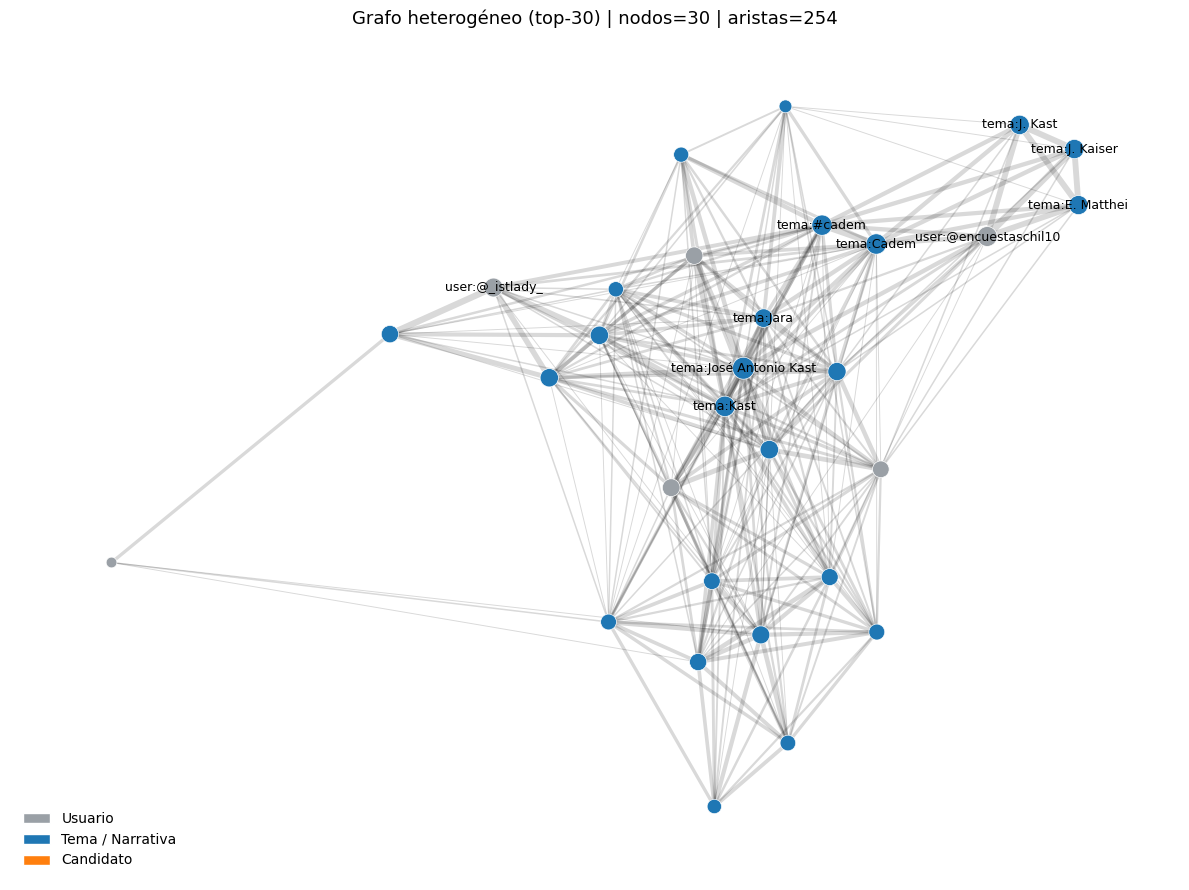

In [142]:
import math
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

# --- 1. Preparar subgrafo top-N ---
if G.number_of_nodes() == 0:
    raise RuntimeError("El grafo G está vacío. Revisa la construcción previa.")

GG = G.to_undirected() if nx.is_directed(G) else G
components = list(nx.connected_components(GG))
Gcc = GG.subgraph(max(components, key=len)).copy()

deg = dict(Gcc.degree(weight='weight'))
topN = 30
nodos_top = [n for n,_ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:topN]]
Gs = Gcc.subgraph(nodos_top).copy()

# --- 2. Colores por tipo de nodo ---
tipo = nx.get_node_attributes(Gs, 'tipo')
color_map = {'user':'#9aa0a6', 'cand':'#ff7f0e', 'tema':'#1f77b4'}
node_colors = [color_map.get(tipo.get(n,'user'), '#9aa0a6') for n in Gs.nodes()]

# --- 3. Tamaño y grosor ---
deg_s = dict(Gs.degree(weight='weight'))
node_sizes = [max(60, 12*math.sqrt(deg_s[n])) for n in Gs.nodes()]
w = [max(0.5, math.log1p(Gs[u][v].get('weight',1))) for u,v in Gs.edges()]

# --- 4. Layout y dibujo ---
pos = nx.spring_layout(Gs, k=0.3, seed=42)
plt.figure(figsize=(12,9))
nx.draw_networkx_edges(Gs, pos, width=w, alpha=0.15)
nx.draw_networkx_nodes(Gs, pos, node_color=node_colors, node_size=node_sizes,
                       edgecolors='white', linewidths=0.5)

# Etiquetas solo para los más conectados
top_labels = set([n for n,_ in sorted(deg_s.items(), key=lambda x: x[1], reverse=True)[:10]])
labels = {n:n for n in Gs.nodes() if n in top_labels}
nx.draw_networkx_labels(Gs, pos, labels=labels, font_size=9)

# --- 5. Leyenda personalizada ---
legend_elements = [
    Patch(facecolor='#9aa0a6', edgecolor='white', label='Usuario'),
    Patch(facecolor='#1f77b4', edgecolor='white', label='Tema / Narrativa'),
    Patch(facecolor='#ff7f0e', edgecolor='white', label='Candidato')
]
plt.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=False)

plt.title(f"Grafo heterogéneo (top-{topN}) | nodos={Gs.number_of_nodes()} | aristas={Gs.number_of_edges()}",
          fontsize=13)
plt.axis('off')
plt.tight_layout()
plt.show()


Este grafo evidencia una red temática concentrada donde los twetts asociados a candidatos específicos comparten un mismo espacio semántico, reforzando la hipótesis de que las comunidades de desinformación se organizan alrededor de narrativas recurrentes y no de usuarios individuales. Esto responde directamente a las preguntas de la Parte 2 sobre qué candidatos y temas se agrupan, qué sesgos reflejan y qué conexiones sostienen la propagación.

WordGraph: 7081 nodos, 59135 aristas


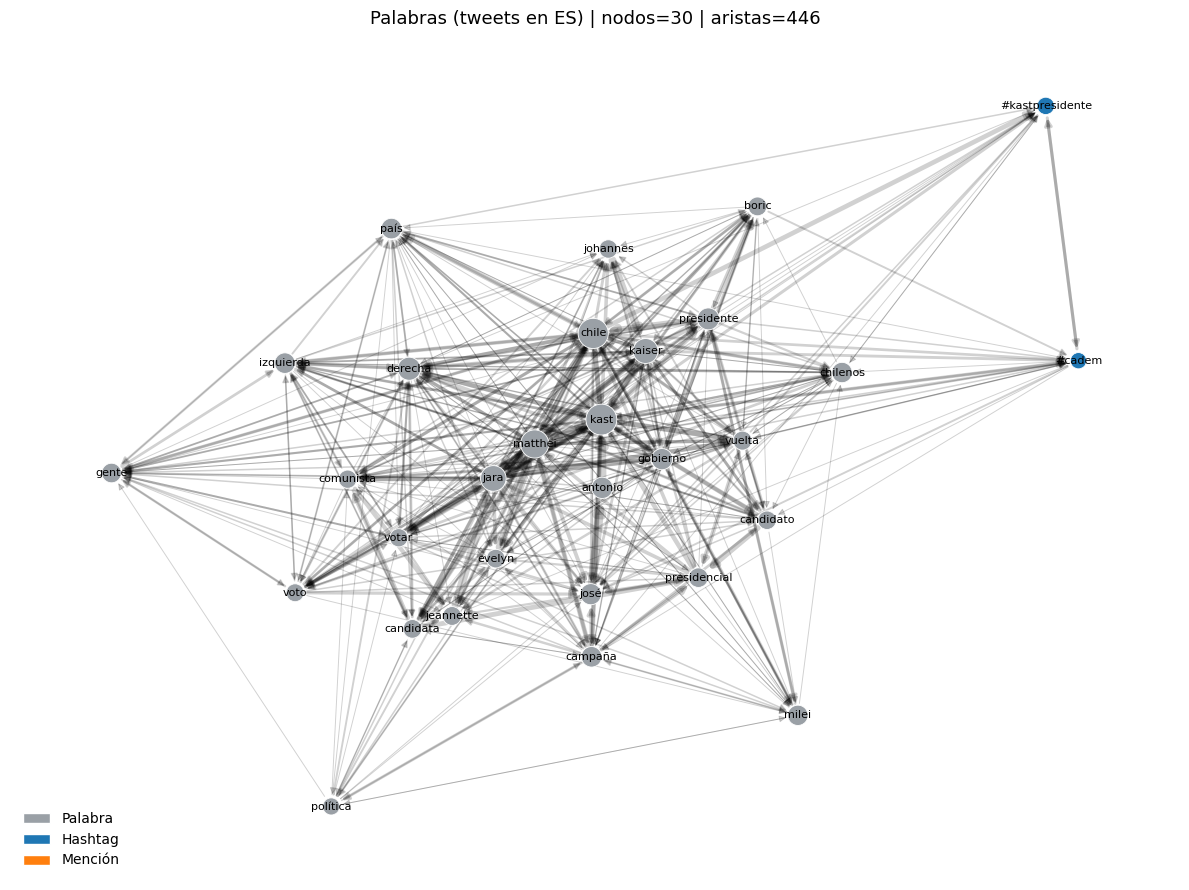

In [161]:
# === B) Grafo de palabras (dirigido, ponderado) ===
import re
from collections import Counter
import spacy
nlp = spacy.load("es_core_news_sm")
STOPWORDS_SPACY = nlp.Defaults.stop_words

# Combinar con tus propias stopwords personalizadas
STOP_CUSTOM = {
    'rt','https','t','co','amp','si','ser','estar','haber','tener','hacer',
    'puede','porque','está','son','ya','aqui','alli','ahi','ahora','solo',
    'cada','todo','asi','muy','mas','menos','ante','entre','desde','segun',
    'tambien','aunque','mientras','donde','cuando','sobre'
}
STOP_ALL = STOPWORDS_SPACY.union(STOP_CUSTOM)


def tokenize_es(text):
    t = str(text).lower()
    t = re.sub(r'https?://\S+|www\.\S+', ' ', t)
    t = re.sub(r'\d+(?:[\.,]\d+)?', ' ', t)
    t = re.sub(r'[^\w#@áéíóúñü]+', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    toks = [w for w in t.split() if len(w) >= 3 and w not in STOP_ALL]
    return toks


def build_word_digraph(texts, min_word_freq=3, window=2):
    Gw = nx.DiGraph()
    word_freq = Counter()
    cooc = Counter()
    for txt in texts:
        toks = tokenize_es(txt)
        if not toks: 
            continue
        word_freq.update(toks)
        L = len(toks)
        for i in range(L-1):
            wi = toks[i]
            for j in range(i+1, min(i+window, L)):
                wj = toks[j]
                cooc[(wi, wj)] += 1
    vocab = {w for w,f in word_freq.items() if f >= min_word_freq}
    for w in vocab:
        Gw.add_node(w, tipo=("hashtag" if w.startswith('#') else "mencion" if w.startswith('@') else "palabra"),
                    freq=word_freq[w])
    for (wi,wj),c in cooc.items():
        if wi in Gw and wj in Gw and wi != wj:
            Gw.add_edge(wi, wj, weight=c)
    isolated = [n for n in Gw if Gw.in_degree(n)+Gw.out_degree(n)==0]
    Gw.remove_nodes_from(isolated)
    return Gw

def plot_word_digraph(Gw, topN_nodes=40, top_labels=15, title_prefix="Grafo de palabras"):
    if Gw.number_of_nodes()==0:
        raise RuntimeError("El grafo de palabras está vacío.")
    pr = nx.pagerank(Gw, weight='weight') if Gw.number_of_edges()>0 else {n:1 for n in Gw}
    top_nodes = [n for n,_ in sorted(pr.items(), key=lambda x:x[1], reverse=True)[:topN_nodes]]
    Gs = Gw.subgraph(top_nodes).copy()
    tipo = nx.get_node_attributes(Gs, 'tipo')
    color_map = {'palabra':'#9aa0a6', 'hashtag':'#1f77b4', 'mencion':'#ff7f0e'}
    node_colors = [color_map.get(tipo.get(n,'palabra'), '#9aa0a6') for n in Gs.nodes()]
    freq = nx.get_node_attributes(Gs, 'freq')
    node_sizes = [max(60, 10*math.sqrt(freq.get(n,1))) for n in Gs.nodes()]
    ew = [max(0.6, math.log1p(Gs[u][v].get('weight',1))) for u,v in Gs.edges()]
    pos = nx.spring_layout(Gs, k=0.35, seed=42, weight='weight')
    plt.figure(figsize=(12,9))
    nx.draw_networkx_edges(Gs, pos, width=ew, alpha=0.18, arrows=True, arrowstyle='-|>', arrowsize=10)
    nx.draw_networkx_nodes(Gs, pos, node_color=node_colors, node_size=node_sizes,
                           edgecolors='white', linewidths=0.6)
    labels = {n:n for n,d in Gs.nodes(data=True) if d['freq'] >= 5}
    nx.draw_networkx_labels(Gs, pos, labels={n: n for n in Gs.nodes()}, font_size=8)

    legend_elements = [
        Patch(facecolor='#9aa0a6', edgecolor='white', label='Palabra'),
        Patch(facecolor='#1f77b4', edgecolor='white', label='Hashtag'),
        Patch(facecolor='#ff7f0e', edgecolor='white', label='Mención')
    ]
    plt.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=False)
    plt.title(f"{title_prefix} | nodos={Gs.number_of_nodes()} | aristas={Gs.number_of_edges()}", fontsize=13)
    plt.axis('off'); plt.tight_layout(); plt.show()

# Construir y dibujar desde tus tweets:
texts = data1['Tweet_Content'].astype(str).tolist()
Gw = build_word_digraph(texts, min_word_freq=3, window=2)
print("WordGraph:", Gw.number_of_nodes(), "nodos,", Gw.number_of_edges(), "aristas")
plot_word_digraph(Gw, topN_nodes=30, top_labels=15, title_prefix="Palabras (tweets en ES)")


### Métodos de detección de comunidades


Este bloque implementa el flujo de comunidades (Louvain) sobre el grafo heterogéneo filtrado a las aristas que mejor explican circulación de narrativas (retweet, mencion, user-tema, coocurre). Primero extrae la componente gigante y preserva los pesos de arista; luego aplica Louvain (best_partition) para maximizar modularidad y etiquetar cada nodo con su Community ID. Se sacan metricas.

In [ ]:
# ========= 0) Requisitos previos =========
import pandas as pd, numpy as np, math, re
import networkx as nx
from collections import defaultdict, Counter

# Si no lo tienes:  pip install python-louvain
try:
    import community as community_louvain
except Exception as e:
    raise RuntimeError("Falta python-louvain. Instala con: pip install python-louvain")

# ========= 1) Elegir grafo para comunidades =========
# Recomiendo el heterogéneo filtrado a las aristas claves (retuits, menciones, user-tema, cand-tema, coocurrencias)
def subgrafo_por_tipos_arista(G, tipos_permitidos):
    H = nx.Graph()
    for u,v,d in G.edges(data=True):
        tipos = d.get('tipos', {})
        if any(t in tipos and tipos[t] > 0 for t in tipos_permitidos):
            if not H.has_node(u): H.add_node(u, **G.nodes[u])
            if not H.has_node(v): H.add_node(v, **G.nodes[v])
            H.add_edge(u, v, **d)
    return H

def componente_gigante(G):
    GG = G.to_undirected() if nx.is_directed(G) else G
    if GG.number_of_nodes() == 0:
        raise RuntimeError("G vacío.")
    comp = max(nx.connected_components(GG), key=len)
    return GG.subgraph(comp).copy()

H = subgrafo_por_tipos_arista(
        G, tipos_permitidos=['retweet','mencion','user-tema','coocurre']
)
H = componente_gigante(H)

print(f"[Heterogéneo filtrado] nodos={H.number_of_nodes()} aristas={H.number_of_edges()}")

# ========= 2) Louvain =========
part = community_louvain.best_partition(H, weight='weight', random_state=42)

# ========= 3) Helpers de “top términos” y conteos =========
tipo = nx.get_node_attributes(H, 'tipo')
degw = dict(H.degree(weight='weight'))

def top_n_en_comunidad(comm_id, kind, k=5):
    """Top-k nodos de tipo 'tema' o 'cand' dentro de la comunidad, por grado ponderado."""
    nodos = [n for n in H.nodes() if part[n]==comm_id and tipo.get(n)=='tema'] if kind=='tema' \
            else [n for n in H.nodes() if part[n]==comm_id and tipo.get(n)=='cand']
    orden = sorted(nodos, key=lambda n: degw.get(n,0), reverse=True)
    # limpiar prefijos tipo "tema:" / "cand:" si es que los tienes
    limpio = []
    for n in orden[:k]:
        if n.startswith("tema:") or n.startswith("cand:") or n.startswith("user:"):
            limpio.append(n.split(":",1)[1])
        else:
            limpio.append(n)
    return limpio

def conteos_por_comunidad():
    rows = []
    com_ids = sorted(set(part.values()))
    for cid in com_ids:
        nodos_c = [n for n in H.nodes() if part[n]==cid]
        # conteos por tipo
        c_users = sum(1 for n in nodos_c if tipo.get(n)=='user')
        c_temas = sum(1 for n in nodos_c if tipo.get(n)=='tema')
        c_cand  = sum(1 for n in nodos_c if tipo.get(n)=='cand')
        rows.append((cid, c_users, c_temas, c_cand))
    df = pd.DataFrame(rows, columns=['comunidad','usuarios','temas','candidatos'])
    return df

# ========= 4) Detección flexible de candidatos directamente desde los tweets =========
import re, unicodedata

def _u(s):  # normaliza tildes y minúsculas
    return unicodedata.normalize('NFKD', str(s).lower()).encode('ascii','ignore').decode('ascii')

# Catálogo con alias / variantes (incluye "meo")
catalogo_candidatos = {
    "Evelyn Matthei": {"evelyn", "matthei"},
    "José Antonio Kast": {"kast", "jose antonio", "josé antonio", "j a kast"},
    "Jeannette Jara": {"jeannette", "jara"},
    "Harold Mayne-Nicholls": {"harold", "mayne", "nicholls", "mayne-nicholls"},
    "Franco Parisi": {"franco", "parisi"},
    "Eduardo Artés": {"eduardo", "artes", "artés"},
    "Johannes Kaiser": {"johannes", "kaiser"},
    "Marco Enríquez-Ominami": {"marco", "enriquez", "ominami", "meo"}
}

# Compilamos patrones con bordes de palabra
patrones_candidatos = {
    canon: [re.compile(rf"\b{re.escape(_u(var))}\b") for var in vars_]
    for canon, vars_ in catalogo_candidatos.items()
}

# Normaliza el handle autor (con @ y minúscula)
def _norm_handle(h):
    h = (h or "").strip().lower()
    return h if h.startswith("@") else ("@"+h if h else "")

data1 = data1.copy()
data1['Author_Handle_norm'] = data1['Author_Handle'].apply(_norm_handle)
data1['Tweet_norm'] = data1['Tweet_Content'].astype(str).apply(_u)

# Detecta candidatos mencionados por tweet
def detectar_cands_texto(t):
    found = set()
    for canon, pats in patrones_candidatos.items():
        if any(p.search(t) for p in pats):
            found.add(canon)
    return list(found)

data1['candidatos_detectados_texto'] = data1['Tweet_norm'].apply(detectar_cands_texto)

# ========= 5) Tabla “Resumen (Louvain)” SIN columnas de bots =========
def top_temas_en_comunidad(comm_id, k=3):
    nodos_tema = [n for n in H.nodes() if part[n]==comm_id and tipo.get(n)=='tema']
    orden = sorted(nodos_tema, key=lambda n: degw.get(n,0), reverse=True)[:k]
    limpio = [n.split(":",1)[1] if ":" in n else n for n in orden]
    return ", ".join(limpio)

# Top candidatos a partir de los tweets de los usuarios de la comunidad
def top_candidatos_en_comunidad(comm_id, k=4):
    # usuarios (nodos 'user') de la comunidad -> handles normalizados
    usuarios = [n for n in H.nodes() if part[n]==comm_id and tipo.get(n)=='user']
    handles = set(n.split(":",1)[1] for n in usuarios if ":" in n)
    if not handles:
        return ""
    # subset de tweets de esos usuarios
    dfc = data1[data1['Author_Handle_norm'].isin(handles)]
    if dfc.empty:
        return ""
    # contar candidatos detectados
    cnt = Counter()
    for lst in dfc['candidatos_detectados_texto']:
        for c in lst:
            cnt[c] += 1
    if not cnt:
        return ""
    top = [c for c,_ in cnt.most_common(k)]
    return ", ".join(top)

# Armar base
com_ids = sorted(set(part.values()))
rows = []
for cid in com_ids:
    nodos_c = [n for n in H.nodes() if part[n]==cid]
    c_users = sum(1 for n in nodos_c if tipo.get(n)=='user')
    c_temas = sum(1 for n in nodos_c if tipo.get(n)=='tema')
    #c_cand  = sum(1 for n in nodos_c if tipo.get(n)=='cand')  # por si en algún futuro sí existen cand:* en G
    rows.append((cid, c_users, c_temas))

base = pd.DataFrame(rows, columns=['comunidad','usuarios','temas'])
base['top_temas'] = base['comunidad'].apply(lambda c: top_temas_en_comunidad(c, k=3))
base['top_candidatos'] = base['comunidad'].apply(lambda c: top_candidatos_en_comunidad(c, k=4))

# Ordenar por tamaño
resumen = base.sort_values(['usuarios','temas'], ascending=[False, False]).reset_index(drop=True)

# Mostrar
print("\nResumen (Louvain):")
display(resumen.head(30))

# Guardar si deseas
resumen.to_csv("../data/resumen_comunidades_louvain.csv", index=False)


[Heterogéneo filtrado] nodos=8570 aristas=47577

Resumen (Louvain):


comunidad  usuarios  temas  \
0           0       403   1226   
1           7       324    627   
2          15       223    422   
3           3       186    524   
4           1       132    462   
5          14       119    190   
6           9       109    444   
7          12        97    503   
8           8        91    115   
9          19        69    150   
10         18        58    113   
11          6        51    331   
12         13        36    237   
13         22        36     41   
14         11        34    112   
15          4        33    162   
16         31        28      5   
17          5        23    158   
18         10        23     77   
19         16        21    137   
20         27        19     17   
21         23        16    137   
22         21        13     68   
23         17        10     31   
24         29         9      7   
25         26         8     51   
26         32         8      3   
27         20         4      0   
28         28         3      6   
29          2         3      5   

                                            top_temas  \
0                       José Antonio Kast, Kast, Jara   
1                          mentira, contra, fake news   
2                             Milei, Ustedes, También   
3           Johannes Kaiser, Kaiser, #kaiseralamoneda   
4   #kastpresidente2026, #kastpresidente, @joseant...   
5                             USTEDES, QUIENES, VOTAR   
6   Jeannette Jara, #jarapresidenta2026, #jaraeschile   
7                UN, #kaiserpresidentedechile, PORQUE   
8                          #granhermano, Solo, ESTABA   
9                                  Maduro, qué, Vamos   
10                             Además, ATENCIÓN, ESTÁ   
11                             #cadem, Cadem, J. Kast   
12                           #chile, #urgente, #ahora   
13                                   Nos, LLA, Hitler   
14          jamás, #mileiestafador, #mileiesunaestafa   
15         #sinfiltros_tv, #sinfiltros, #sinfiltrostv   
16               Arévalo, dEmOcRatZia, Samantha Power   
17                            IZQUIERDA, CAMPAÑA, ASI   
18       Gabriel Boric, Sebastián Piñera, #contigochv   
19                     DDHH, PRESIDENTA, REPUBLICANOS   
20           Massive Caller, GutierrezPriego49, @SCJN   
21                      PUEBLO, #noalcomunismo, DESDE   
22                      Jadue, Islámicos Hamas, RT RT   
23       daño, Partido de la Gente, #francoparisi2026   
24           Has, calcomania de Milei, veia potencial   
25                          PODER, #bolivia, Cobardía   
26          General Roosvelt, ¿ qué interés, Cossette   
27                                                      
28                          Estás, BCRA, Estimadísimo   
29                             LEIRE, FONTANERA, Lean   

                                       top_candidatos  
0   José Antonio Kast, Evelyn Matthei, Jeannette J...  
1   José Antonio Kast, Evelyn Matthei, Johannes Ka...  
2   José Antonio Kast, Evelyn Matthei, Johannes Ka...  
3   Johannes Kaiser, José Antonio Kast, Evelyn Mat...  
4   José Antonio Kast, Jeannette Jara, Evelyn Matt...  
5   Evelyn Matthei, José Antonio Kast, Jeannette J...  
6   Evelyn Matthei, Jeannette Jara, José Antonio K...  
7   Johannes Kaiser, José Antonio Kast, Jeannette ...  
8   Jeannette Jara, Johannes Kaiser, Marco Enríque...  
9   Jeannette Jara, José Antonio Kast, Evelyn Matthei  
10  José Antonio Kast, Evelyn Matthei, Jeannette J...  
11  José Antonio Kast, Jeannette Jara, Evelyn Matt...  
12  José Antonio Kast, Evelyn Matthei, Jeannette J...  
13                                                     
14  Evelyn Matthei, José Antonio Kast, Jeannette J...  
15  José Antonio Kast, Johannes Kaiser, Evelyn Mat...  
16                             Marco Enríquez-Ominami  
17  José Antonio Kast, Evelyn Matthei, Jeannette J...  
18  José Antonio Kast, Evelyn Matthei, Johannes Ka...  
19  José Antonio Kast, Evelyn Matthei, Johannes Ka...  
20   

### Extracción de asociaciones temáticas clave

Este bloque genera, para cada comunidad Louvain, un resumen temático combinando tres enfoques: TF-IDF (1–2-gramas) que destaca términos característicos, hashtags más usados que revelan consignas o temas explícitos y bigramas por PMI que muestran asociaciones semánticas fuertes.

Resumen temático por comunidad:


comunidad  usuarios  n_tweets  \
0           0       403      2020   
1           7       324       559   
2          15       223       337   
3           3       186       564   
4           1       132       510   
5          14       119       263   
6           9       109       312   
7          12        97       163   
8           8        91        87   
9          19        69        72   
10         18        58        62   
11          6        51       388   
12         13        36       156   
13         22        36        28   
14         11        34        46   

                                            top_tfidf  \
0   kast, matthei, chile, jara, josé, antonio, ant...   
1   más, kast, mentira, chile, matthei, está, bots...   
2   milei, kukas, más, presidente, está, chile, so...   
3   kaiser, chile, johannes, johannes kaiser, kast...   
4   chile, kast, kastpresidente2026, kastpresident...   
5   chile, derecha, matthei, kast, jara, chilenos,...   
6   chile, matthei, kast, jara, jeannette, jeannet...   
7   kaiser, chile, johannes, comunista, johannes k...   
8   santiago, luz, más, voto, votos, está, chile, ...   
9   fraude, luisa, más, electoral, elecciones, cor...   
10  denuncia, está, además, chile, martín, derecha...   
11  kast, jara, cadem, matthei, encuesta, parisi, ...   
12  chile, kast, matthei, jara, encuesta, kaiser, ...   
13  arte, más, derecha, presidente, jamás, montaje...   
14  mileiestafador, milei, justicia, vos, jamás, m...   

                                         top_hashtags  \
0   #mesacentral, #kastpresidente2026, #cadem, #ka...   
1   #fakenews, #nestormiente, #kastpresidente, #rt...   
2   #noestánlosvotos, #noestanlosvotos, #mileiesta...   
3   #kaiseralamoneda, #kaiser2026, #káiser2026, #j...   
4   #kastpresidente2026, #kastpresidente, #kastpre...   
5   #chilepaisanticomunista, #santiagoagoniza, #cr...   
6   #jarapresidenta2026, #jaraeschile, #jaranosune...   
7   #kaiserpresidentedechile, #kaiserpresidente202...   
8   #granhermano, #granfuria, #lam, #votojara, #ju...   
9   #megafraude, #semanasanta, #ecuador, #transpar...   
10  #sargentochala, #correismoesfraude, #laderecha...   
11  #cadem, #elecciones2025cl, #criteria, #encuest...   
12  #lavozdelosquesobran, #artés, #cambioporchile,...   
13              #labaseamlat, #novolveran, #nopasaran   
14  #mileiestafador, #bullrichasesina, #renunciami...   

                                      top_bigrams_pmi  
0   the clinic, karol cariola, secreto bancario, j...  
1   jose antonio, consulta popular, jeannette jara...  
2                         campana sucia, encore chile  
3   jose antonio, reforma pensiones, nacional libe...  
4   crimen organizado, inmigracion ilegal, cambio ...  
5   jeannette jara, candidata presidencial, vota v...  
6   detalles aca, fake news, jose antonio, johanne...  
7                                     johannes kaiser  
8                                    cata granhermano  
9                                                      
10                                                     
11  rodolfo carter, votante obligado, panel ciudad...  
12  ale valle, rodrigo herrera, franco parisi, jos...  
13                                                     
14

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1624296996.py:230: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1624296996.py:231: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])


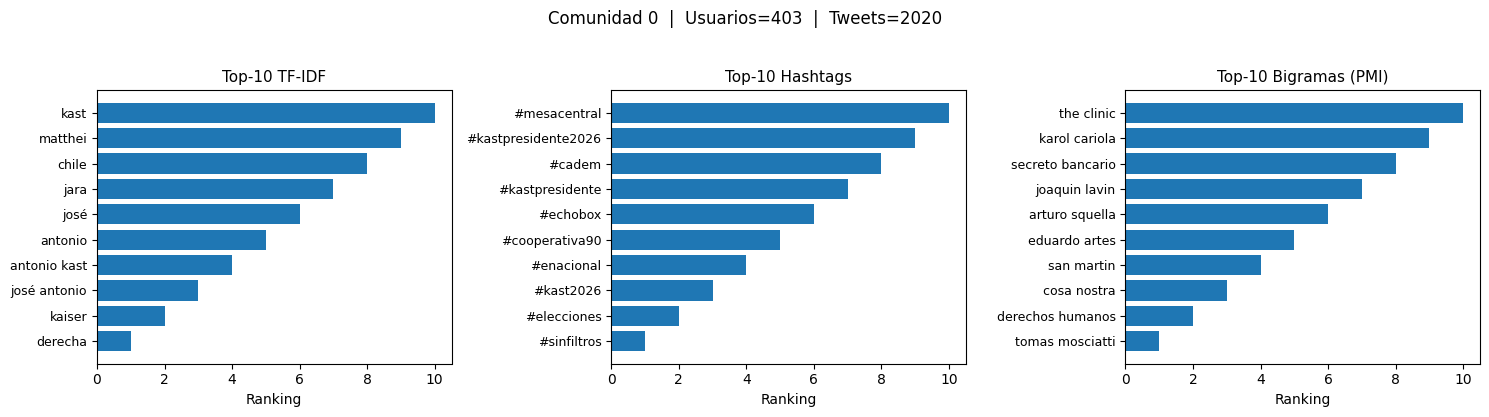

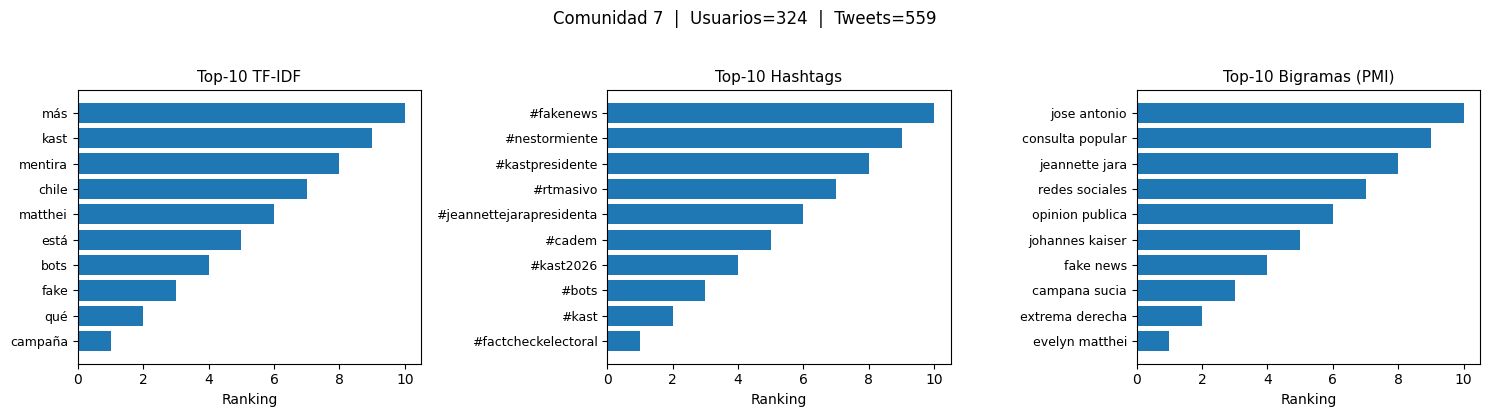

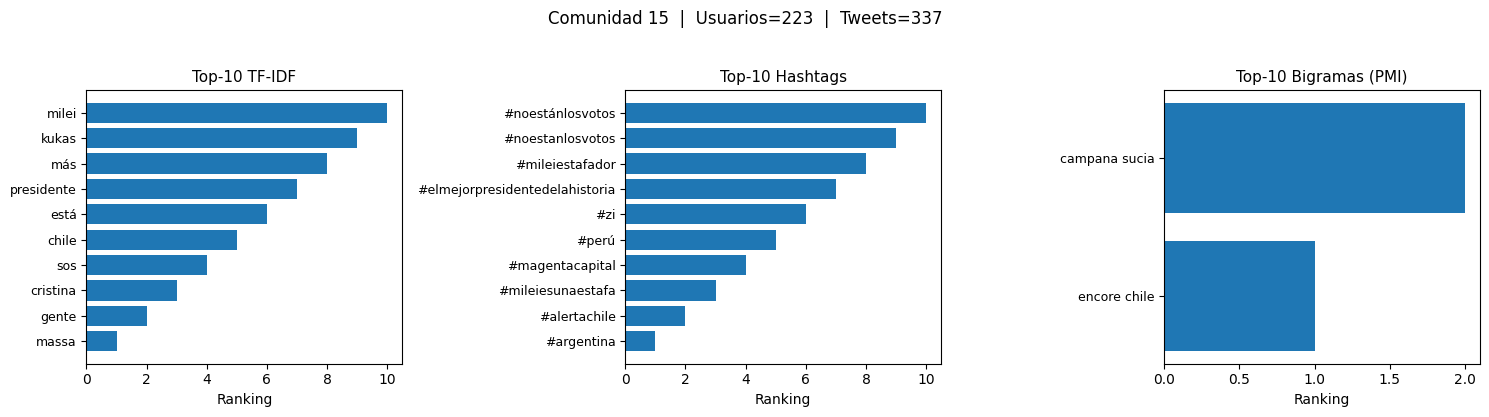

In [172]:
# =========================
# 0) Imports y helpers
# =========================
import re, string, math, unicodedata
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt

# --- Chequeos mínimos (puedes comentar si ya estás seguro)
assert 'data1' in globals(), "Falta el DataFrame data1 con los tweets."
assert 'H' in globals() and 'part' in globals() and 'tipo' in globals(), "Falta el grafo H, la partición 'part' o el dict 'tipo'."

# --- Regex útiles
URL_RE     = re.compile(r'https?://\S+')
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#\w+')
PUNCT_TABLE = str.maketrans('', '', string.punctuation + "“”‘’´`…—–")

# =========================
# 1) Stopwords desde spaCy (es), normalizadas
# =========================
import spacy
from spacy.lang.es.stop_words import STOP_WORDS

# Carga spaCy (asegúrate de haber hecho: python -m spacy download es_core_news_sm)
nlp = spacy.load("es_core_news_sm")

def _norm(s):
    # Normaliza a minúsculas y sin tildes
    return unicodedata.normalize("NFKD", str(s).lower()).encode("ascii","ignore").decode("ascii")

# Conjunto de stopwords normalizadas
STOP_ES = {_norm(w) for w in STOP_WORDS}
# Añade ruido típico de Twitter / web
STOP_ES |= {
    "rt","via","https","http","com","www","solo","mas","todas","todos","toda","todo",
    # números sueltos comunes
    "2023","2024","2025","000","00","01","10","20"
}

# (Opcional) stop-hashtags muy generales
STOP_HASHTAGS = {"#chile","#ahora","#urgente","#ultimahora","#noticia","#politica","#news"}

# =========================
# 2) Limpieza, tokenización y extracción de hashtags
# =========================
def clean_for_tokens(t):
    t = URL_RE.sub(' ', str(t))
    t = MENTION_RE.sub(' ', t)           # quita @menciones
    t = t.lower().translate(PUNCT_TABLE) # quita puntuación
    t = re.sub(r'\s+', ' ', t).strip()
    return t

def tokenize(text):
    # Normaliza para comparar contra STOP_ES
    t_norm = _norm(text)
    toks = [w for w in t_norm.split() if w.isalpha() and len(w) > 2]
    return toks

def doc_to_tokens(doc):
    toks = tokenize(clean_for_tokens(doc))
    toks = [w for w in toks if w not in STOP_ES]
    return toks

def extract_hashtags(text):
    hts = [h.lower() for h in HASHTAG_RE.findall(str(text))]
    return [h for h in hts if h not in STOP_HASHTAGS]

# =========================
# 3) Mapear usuarios por comunidad y armar corpus por comunidad
# =========================
# usuarios (nodos 'user') por comunidad
com_to_users = defaultdict(list)
for n in H.nodes():
    if tipo.get(n) == 'user':
        cid = part[n]
        handle = n.split(":", 1)[1] if ":" in n else n
        com_to_users[cid].append(handle)

# Normaliza handles del DataFrame para unir con nodos
data1 = data1.copy()
data1['_handle_norm'] = data1['Author_Handle'].astype(str).str.strip().str.lower()
data1['_handle_norm'] = data1['_handle_norm'].apply(lambda h: h if h.startswith('@') else ('@'+h if h else ''))

# Construir corpus/hashtags por comunidad
com_to_docs = {}
com_to_hashtags = {}
com_to_ntweets = {}

for cid, handles in com_to_users.items():
    dfc = data1[data1['_handle_norm'].isin(handles)]
    com_to_ntweets[cid] = len(dfc)
    docs = dfc['Tweet_Content'].dropna().astype(str).tolist()
    com_to_docs[cid] = docs
    # hashtags
    all_hts = []
    for txt in docs:
        all_hts.extend(extract_hashtags(txt))
    com_to_hashtags[cid] = all_hts

# Si no hay comunidades (raro), corta acá
if not com_to_docs:
    raise RuntimeError("No se encontraron documentos por comunidad. Revisa H/part/tipo y los handles en data1.")

# =========================
# 4) TF-IDF (1–2-gramas) por comunidad
# =========================
from sklearn.feature_extraction.text import TfidfVectorizer

cids_sorted = sorted(com_to_docs.keys())
docs_by_com = [" ".join(com_to_docs[c]) for c in cids_sorted]

# Vectorizador: usamos stopwords de spaCy y preprocessor de limpieza
tfv = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),
    min_df=5,
    max_df=0.85,
    stop_words=list(STOP_ES),
    preprocessor=clean_for_tokens
)
X = tfv.fit_transform(docs_by_com)
terms = tfv.get_feature_names_out()

def top_k_tfidf_for_row(rowvec, k=10):
    arr = rowvec.toarray().ravel()
    if arr.size == 0:
        return []
    idx = np.argsort(-arr)[:k]
    return [terms[i] for i in idx if arr[i] > 0]

com_top_tfidf = {}
for i, cid in enumerate(cids_sorted):
    com_top_tfidf[cid] = top_k_tfidf_for_row(X[i], k=10)

# =========================
# 5) Top-10 hashtags por comunidad (frecuencia)
# =========================
com_top_hashtags = {}
for cid in cids_sorted:
    cnt = Counter(com_to_hashtags[cid])
    com_top_hashtags[cid] = [h for h,_ in cnt.most_common(10)]

# =========================
# 6) Bigramas por PMI (asociaciones fuertes) por comunidad
# =========================
def bigrams_from_tokens(tokens):
    return [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]

def pmi_bigrams(docs, min_count=8):
    # Cuenta unigrams y bigrams con tokens ya limpios (STOP_ES)
    uni = Counter()
    bi  = Counter()
    total_tokens = 0
    for doc in docs:
        toks = doc_to_tokens(doc)
        total_tokens += len(toks)
        uni.update(toks)
        bi.update(bigrams_from_tokens(toks))
    if total_tokens == 0:
        return []
    total_bigrams = sum(bi.values())
    scores = []
    for (w1, w2), fxy in bi.items():
        if fxy < min_count:
            continue
        px = uni[w1] / total_tokens
        py = uni[w2] / total_tokens
        pxy = fxy / total_bigrams
        if px > 0 and py > 0 and pxy > 0:
            pmi = math.log(pxy / (px * py) + 1e-12)
            scores.append((f"{w1} {w2}", pmi, fxy))
    # ordenar por PMI, desempatar por frecuencia
    scores.sort(key=lambda x: (x[1], x[2]), reverse=True)
    return [s[0] for s in scores[:10]]

com_top_pmi = {}
for cid in cids_sorted:
    com_top_pmi[cid] = pmi_bigrams(com_to_docs[cid], min_count=8)

# =========================
# 7) Tabla final: temas_por_comunidad
# =========================
rows = []
for cid in cids_sorted:
    usuarios = len(com_to_users[cid])
    n_tweets = com_to_ntweets.get(cid, 0)
    top_tfidf = ", ".join(com_top_tfidf.get(cid, []))
    top_hashtags = ", ".join(com_top_hashtags.get(cid, []))
    top_pmi = ", ".join(com_top_pmi.get(cid, []))
    rows.append((cid, usuarios, n_tweets, top_tfidf, top_hashtags, top_pmi))

temas_por_comunidad = pd.DataFrame(
    rows, columns=['comunidad','usuarios','n_tweets','top_tfidf','top_hashtags','top_bigrams_pmi']
).sort_values(['usuarios','n_tweets'], ascending=[False, False]).reset_index(drop=True)

print("Resumen temático por comunidad:")
display(temas_por_comunidad.head(15))

# (Opcional) Guardar CSV
temas_por_comunidad.to_csv("../data/temas_por_comunidad.csv", index=False)

# =========================
# 8) Visualización: subfiguras por comunidad (TF-IDF / Hashtags / PMI)
# =========================
def plot_top_list_ax(ax, items, title):
    items = [i for i in items if i]   # limpia vacíos
    labels = items[:10][::-1]         # top-10, invertido para mayor abajo
    vals = list(range(1, len(labels)+1))  # ranking 1..10
    if len(labels) == 0:
        ax.text(0.5, 0.5, "Sin datos", ha="center", va="center")
        ax.set_axis_off()
        return
    ax.barh(labels, vals)
    ax.set_title(title, fontsize=11)
    ax.set_xlabel("Ranking")
    ax.tick_params(axis='y', labelsize=9)

# ¿Cuántas comunidades mostrar?
K = 3
top_cids = temas_por_comunidad.head(K)['comunidad'].tolist()

for cid in top_cids:
    tfidf_list = com_top_tfidf.get(cid, [])
    htag_list  = com_top_hashtags.get(cid, [])
    pmi_list   = com_top_pmi.get(cid, [])

    # Info para el título
    usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
    n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Comunidad {cid}  |  Usuarios={usuarios}  |  Tweets={n_tweets}",
                 fontsize=12, y=1.03)

    plot_top_list_ax(axes[0], tfidf_list, "Top-10 TF-IDF")
    plot_top_list_ax(axes[1], htag_list,  "Top-10 Hashtags")
    plot_top_list_ax(axes[2], pmi_list,   "Top-10 Bigramas (PMI)")

    plt.tight_layout()
    plt.show()


El análisis de comunidades Louvain da que la conversación electoral en Twitter está altamente concentrada en torno a los candidatos José Antonio Kast, Evelyn Matthei y Jeannette Jara, quienes dominan la mayoría de los clústeres detectados.

Las comunidades más grandes combinan mensajes de campaña, encuestas y etiquetas de apoyo, mientras que otras más pequeñas difunden narrativas específicas (fraude electoral, fake news, o apoyo a figuras como Milei y Kaiser). 

### Visualización con nubes de palabras y grafos

Este bloque genera nubes de palabras comparativas por comunidad, visualizando los términos más representativos según tres criterios: TF-IDF, hashtags y bigramas por PMI. Para cada una de las tres comunidades principales, combina las palabras más relevantes de su corpus y produce paneles paralelos que resumen de forma intuitiva los temas dominantes. Se valida lo encontrado en el item anterior.

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\2732807921.py:25: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\2732807921.py:26: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])


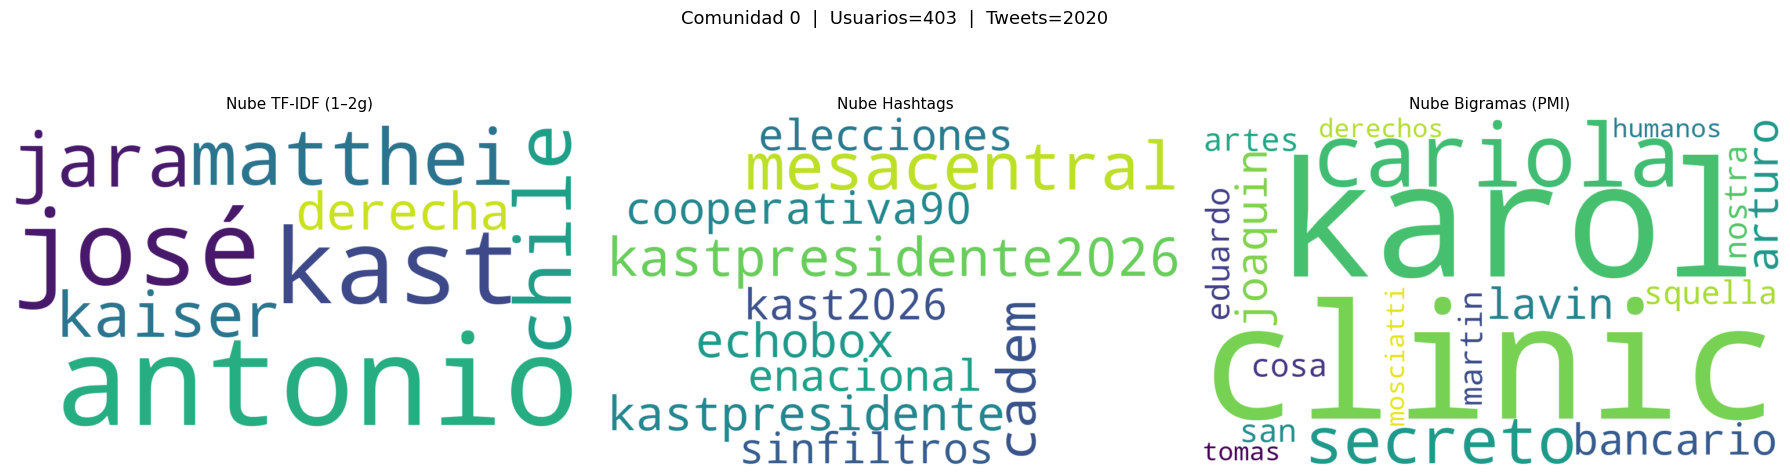

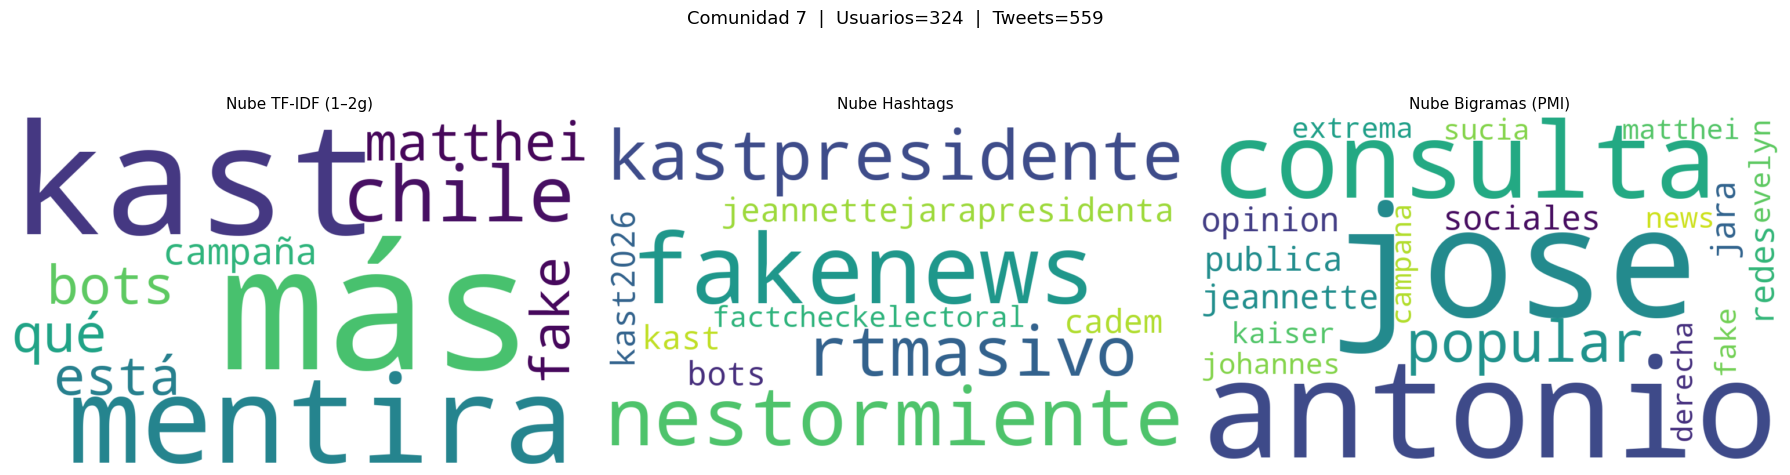

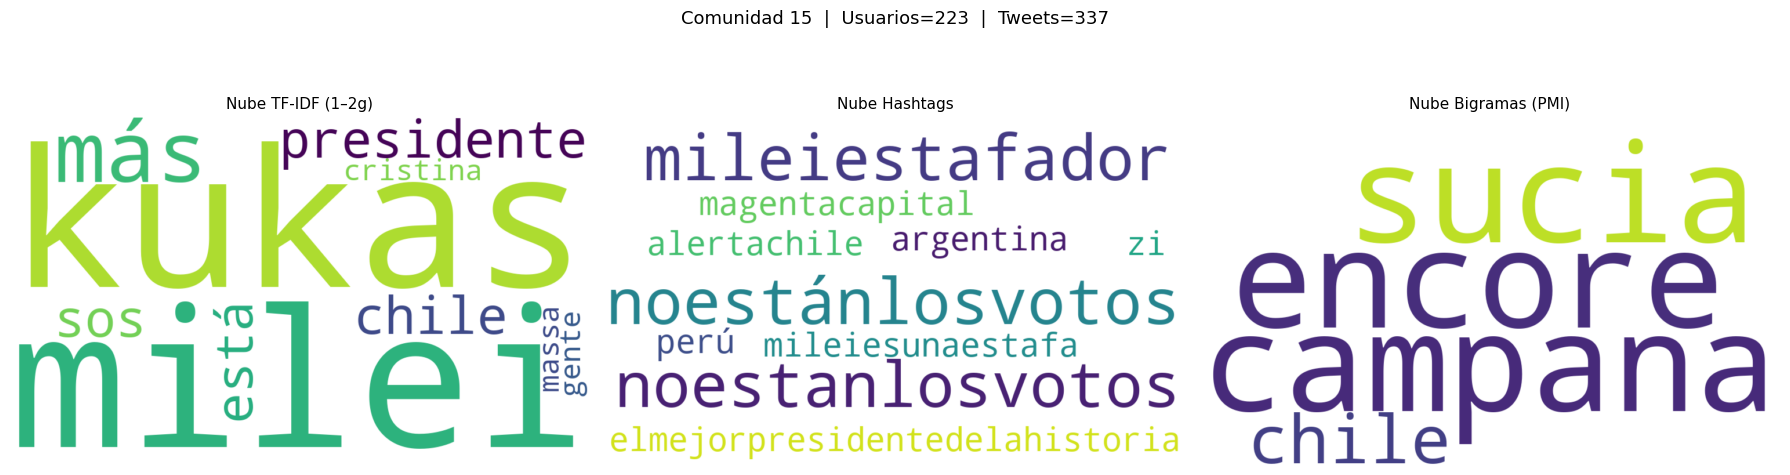

In [176]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud_on_ax(ax, items, title, width=1000, height=600):
    """Dibuja una nube de palabras en el eje 'ax' usando la lista 'items'."""
    text = " ".join(items) if isinstance(items, list) else str(items)
    ax.set_title(title, fontsize=11)
    ax.axis('off')
    if not text.strip():
        ax.text(0.5, 0.5, "Sin datos", ha='center', va='center')
        return
    wc = WordCloud(width=width, height=height, background_color="white")
    img = wc.generate(text)
    ax.imshow(img, interpolation="bilinear")

# ¿Cuántas comunidades mostrar?
K = 3
top_cids = temas_por_comunidad.head(K)['comunidad'].tolist()

for cid in top_cids:
    tfidf_list = com_top_tfidf.get(cid, [])
    htag_list  = com_top_hashtags.get(cid, [])
    pmi_list   = com_top_pmi.get(cid, [])

    usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
    n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"Comunidad {cid}  |  Usuarios={usuarios}  |  Tweets={n_tweets}", fontsize=13, y=1.03)

    wordcloud_on_ax(axes[0], tfidf_list, "Nube TF-IDF (1–2g)")
    wordcloud_on_ax(axes[1], htag_list,  "Nube Hashtags")
    wordcloud_on_ax(axes[2], pmi_list,   "Nube Bigramas (PMI)")

    plt.tight_layout()
    plt.show()


Este bloque construye, para cada comunidad, un grafo de narrativas por co-ocurrencia mezclando tres señales: unigramas TF-IDF (gris), bigramas con alta PMI (naranjo) y hashtags (azul). Cuenta cuántas veces los términos aparecen juntos en el mismo tuit, filtra por umbral de arista (MIN_EDGE), pondera grosores por fuerza de co-ocurrencia y mantiene sólo los nodos más informativos (MAX_NODES). Los resultados se ven en los grafos alfinal

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:157: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])


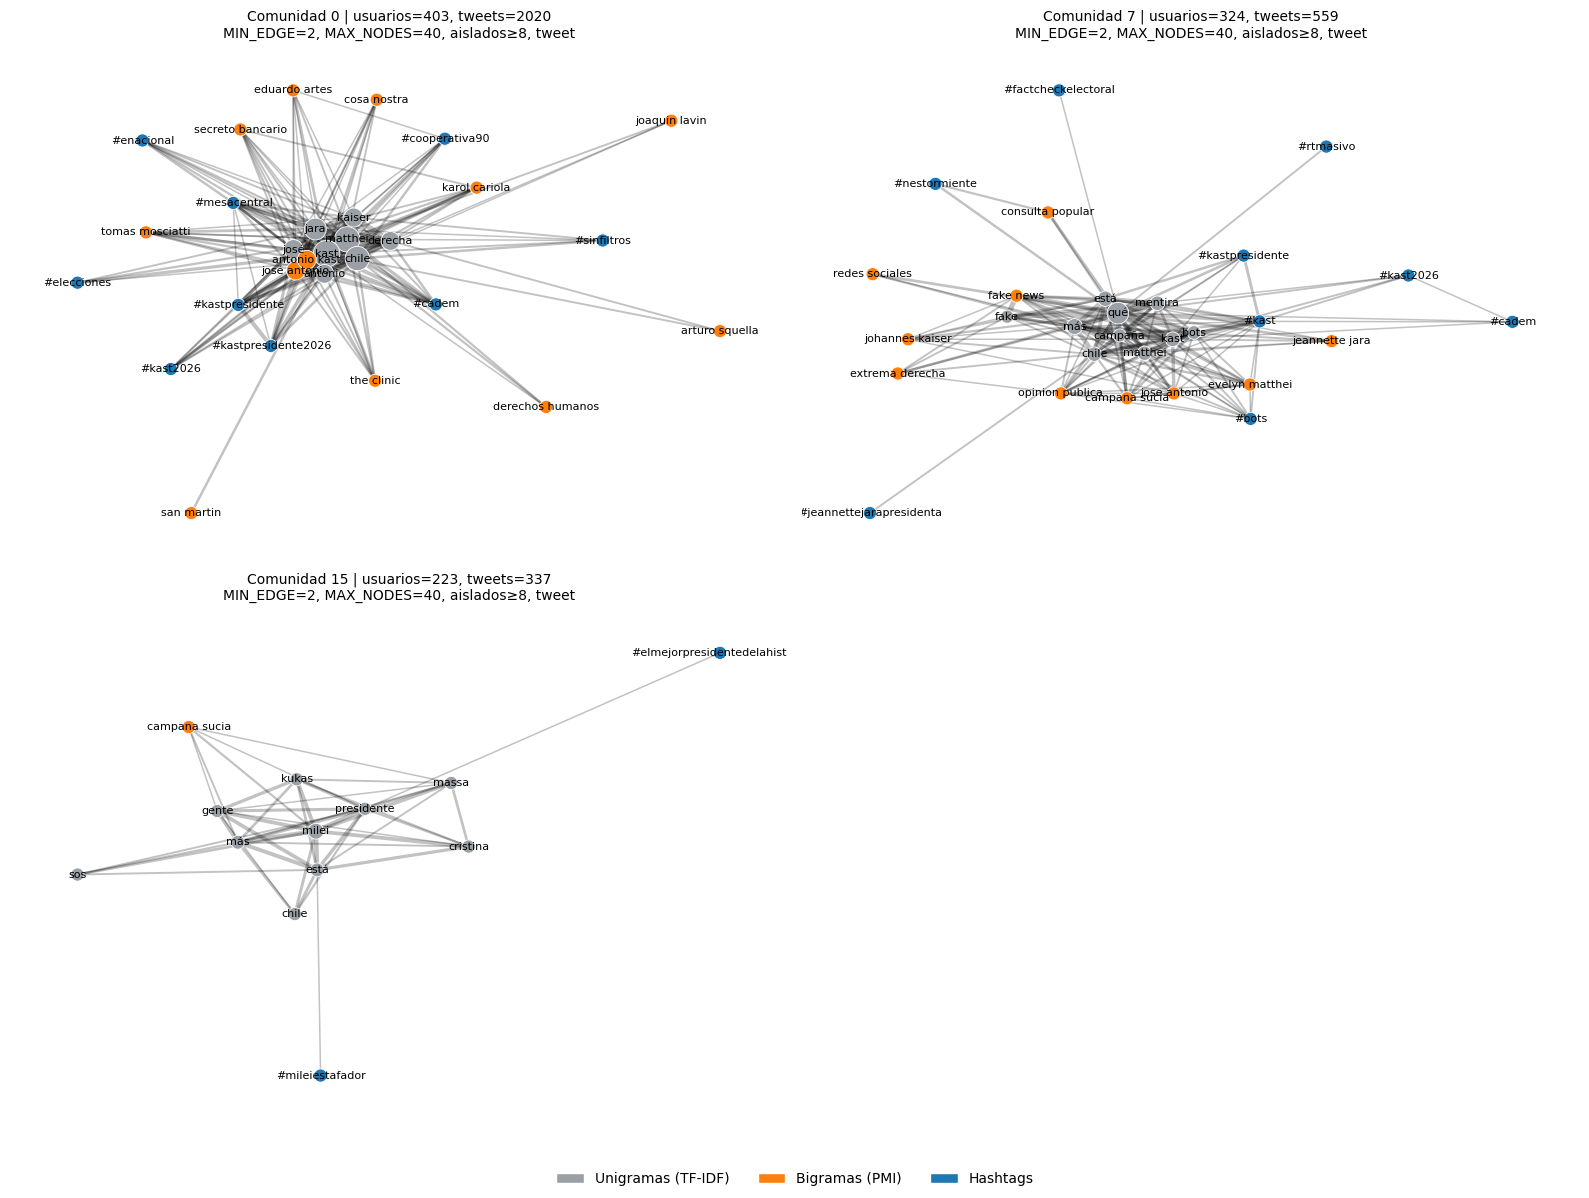

In [184]:
import re, math, itertools, unicodedata
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ===== utilidades de limpieza/matching =====
def _norm(s):
    return unicodedata.normalize("NFKD", str(s).lower()).encode("ascii","ignore").decode("ascii")

def _clean_basic(t):
    t = re.sub(r'https?://\S+', ' ', str(t))
    t = re.sub(r'@\w+', ' ', t)
    t = re.sub(r'\s+', ' ', t).strip()
    return t

def _term_in_text(term, text_clean, hashtag_prefix=True):
    """Match normalizado: hashtags por prefijo opcional; bigramas literal; unigramas con \b."""
    q = _norm(term)
    t = _norm(text_clean)
    if q.startswith('#'):
        return (f" {q} " in f" {t} ") or (hashtag_prefix and q in t)
    if " " in q:  # bigrama literal
        return q in t
    return re.search(rf"\b{re.escape(q)}\b", t) is not None

def _window_tokens(text, window=10):
    toks = _norm(_clean_basic(text)).split()
    return toks, window

# ===== grafo de narrativas con más control =====
def narrativa_graph_on_ax(
    ax, cid,
    terms_tfidf=14, terms_hashtags=10, terms_pmi=12,
    MIN_EDGE=2, MAX_NODES=40,
    KEEP_ISOLATED_MINFREQ=8,
    COOC_SCOPE='tweet',  # 'tweet' o 'window'
    WINDOW=10,
    EDGE_METRIC='count', # 'count' o 'pmi'
    layout='spring'
):
    # 1) set de términos (sin duplicados, manteniendo orden)
    pool = []
    pool += com_top_tfidf.get(cid, [])[:terms_tfidf]
    pool += com_top_hashtags.get(cid, [])[:terms_hashtags]
    pool += com_top_pmi.get(cid, [])[:terms_pmi]
    seen, terms = set(), []
    for t in pool:
        if t and t not in seen:
            seen.add(t); terms.append(t)

    docs = com_to_docs.get(cid, [])
    if not terms or not docs:
        ax.text(0.5, 0.5, "Sin datos", ha="center", va="center"); ax.axis('off'); return None

    # 2) frecuencias y co-ocurrencias
    from collections import Counter
    node_freq = Counter()
    edge_freq = Counter()
    uni = Counter()  # para PMI local
    bi  = Counter()

    for txt in docs:
        txtc = _clean_basic(txt)
        present = [t for t in terms if _term_in_text(t, txtc)]
        if COOC_SCOPE == 'tweet':
            # coocurrencia a nivel tweet
            if present:
                for t in set(present): node_freq[t] += 1
                for a, b in itertools.combinations(sorted(set(present)), 2):
                    edge = tuple(sorted((a, b))); edge_freq[edge] += 1
        else:
            # coocurrencia por ventana de tokens (captura asociaciones más locales)
            toks, W = _window_tokens(txtc, window=WINDOW)
            # contar unigramas de términos presentes
            pres = set([t for t in terms if _term_in_text(t, txtc)])
            for t in pres: node_freq[t] += 1
            # bigramas de términos por ventana (aprox): si ambos en una misma ventana
            if pres and toks:
                # indices de aparición aproximada por búsqueda simple
                idx = {t: [] for t in pres}
                for i, tok in enumerate(toks):
                    for t in pres:
                        q = _norm(t).lstrip('#')
                        if q in tok:
                            idx[t].append(i)
                ps = sorted(pres)
                for a, b in itertools.combinations(ps, 2):
                    ia = idx.get(a, []); ib = idx.get(b, [])
                    if not ia or not ib: continue
                    co = any(abs(i - j) <= W for i in ia for j in ib)
                    if co:
                        edge = (a, b) if a < b else (b, a)
                        edge_freq[edge] += 1

    # 3) pesos de arista
    if EDGE_METRIC == 'pmi':
        # PMI local con aproximación: pxy ~ coocs / sum(coocs); px ~ freq(node)/sum(freqs)
        total_edges = sum(edge_freq.values()) or 1
        total_nodes = sum(node_freq.values()) or 1
        def w_pmi(a, b):
            pxy = edge_freq[(a,b)] / total_edges
            px  = node_freq[a] / total_nodes
            py  = node_freq[b] / total_nodes
            return math.log((pxy / (px*py + 1e-12)) + 1e-12)
        weighted_edges = {e: w_pmi(*e) for e in edge_freq}
    else:
        weighted_edges = edge_freq  # conteo

    # 4) construir grafo
    Gc = nx.Graph()
    for t, f in node_freq.items():
        Gc.add_node(t, freq=f)
    for (a, b), w in weighted_edges.items():
        if w >= MIN_EDGE if EDGE_METRIC == 'count' else w > 0:
            Gc.add_edge(a, b, weight=float(w))

    # conservar aislados “importantes”
    aislados = [n for n, d in Gc.degree() if d == 0 and node_freq.get(n,0) < KEEP_ISOLATED_MINFREQ]
    Gc.remove_nodes_from(aislados)

    if Gc.number_of_nodes() == 0:
        ax.text(0.5, 0.5, f"Sin co-ocurrencias (MIN_EDGE={MIN_EDGE})", ha="center", va="center"); ax.axis('off'); return None

    # 5) limitar a MAX_NODES por score
    deg_w = dict(Gc.degree(weight='weight'))
    score = {n: node_freq.get(n,0) + deg_w.get(n,0) for n in Gc.nodes()}
    keep = [n for n,_ in sorted(score.items(), key=lambda x: x[1], reverse=True)[:min(MAX_NODES, len(score))]]
    S = Gc.subgraph(keep).copy()
    if S.number_of_nodes() == 0:
        ax.text(0.5, 0.5, "Subgrafo vacío tras MAX_NODES", ha="center", va="center"); ax.axis('off'); return None

    # 6) dibujo
    nf = node_freq
    node_sizes = [max(90, 12*math.sqrt(nf.get(n, 1))) for n in S.nodes()]
    if EDGE_METRIC == 'count':
        edge_widths = [max(0.6, math.log1p(S[u][v]['weight'])) for u, v in S.edges()]
    else:
        # escala PMI a [0.8, 4] para grosor
        w = np.array([S[u][v]['weight'] for u, v in S.edges()])
        w = (w - w.min()) / (w.ptp() + 1e-9)
        edge_widths = list(0.8 + 3.2*w)

    def node_color(n):
        if n.startswith('#'):  return '#1f77b4'  # hashtags
        if ' ' in n:          return '#ff7f0e'  # bigramas
        return '#9aa0a6'                      # unigrama

    node_colors = [node_color(n) for n in S.nodes()]
    pos = nx.kamada_kawai_layout(S) if layout == 'kamada' else nx.spring_layout(S, k=0.45, seed=42)
    ax.axis('off')
    nx.draw_networkx_edges(S, pos, width=edge_widths, alpha=0.24, ax=ax)
    nx.draw_networkx_nodes(S, pos, node_size=node_sizes, node_color=node_colors,
                           edgecolors='white', linewidths=0.6, ax=ax)
    nx.draw_networkx_labels(S, pos, font_size=8, ax=ax)

    usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
    n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])
    ax.set_title(f"Comunidad {cid} | usuarios={usuarios}, tweets={n_tweets}\n"
                 f"MIN_EDGE={MIN_EDGE}, MAX_NODES={MAX_NODES}, aislados≥{KEEP_ISOLATED_MINFREQ}, {COOC_SCOPE}", fontsize=10)
    return S

# ===== subfiguras (grilla) =====
K = 3
MIN_EDGE = 2
MAX_NODES = 40
KEEP_ISOLATED_MINFREQ = 8
COOC_SCOPE = 'tweet'    # prueba también 'window'
WINDOW = 10
EDGE_METRIC = 'count'   # prueba también 'pmi'
LAYOUT = 'spring'

top_cids = temas_por_comunidad.head(K)['comunidad'].tolist()
ncols = 2
nrows = int(np.ceil(len(top_cids) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6*nrows))
axes = np.array(axes).reshape(nrows, ncols)

for i, cid in enumerate(top_cids):
    r, c = divmod(i, ncols)
    narrativa_graph_on_ax(
        axes[r, c], cid,
        terms_tfidf=14, terms_hashtags=10, terms_pmi=12,
        MIN_EDGE=MIN_EDGE, MAX_NODES=MAX_NODES,
        KEEP_ISOLATED_MINFREQ=KEEP_ISOLATED_MINFREQ,
        COOC_SCOPE=COOC_SCOPE, WINDOW=WINDOW,
        EDGE_METRIC=EDGE_METRIC, layout=LAYOUT
    )

for j in range(i+1, nrows*ncols):
    r, c = divmod(j, ncols)
    axes[r, c].axis('off')

legend = [
    Patch(facecolor='#9aa0a6', edgecolor='white', label='Unigramas (TF-IDF)'),
    Patch(facecolor='#ff7f0e', edgecolor='white', label='Bigramas (PMI)'),
    Patch(facecolor='#1f77b4', edgecolor='white', label='Hashtags'),
]
plt.figlegend(handles=legend, loc='lower center', ncol=3, frameon=False, fontsize=10)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


### Comparación de trafico (Humanos VS Cuentas sospechosas)

Este bloque une la detección de bots con las comunidades Louvain, es decir,  normaliza handles, mapea cada usuario a su comunidad del grafo H y calcula, por comunidad, el % de cuentas automatizadas. Con eso arma un tablero com_overview y genera una “ficha de comunidad” que, en un panel, lista top cuentas sospechosas y humanas , en el otro, dibuja el grafo de narrativas del cluster.


=== Fichas: comunidades POTENCIADAS POR BOTS ===

=== Fichas: comunidades DOMINADAS POR HUMANOS ===


C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:157: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\3725326967.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


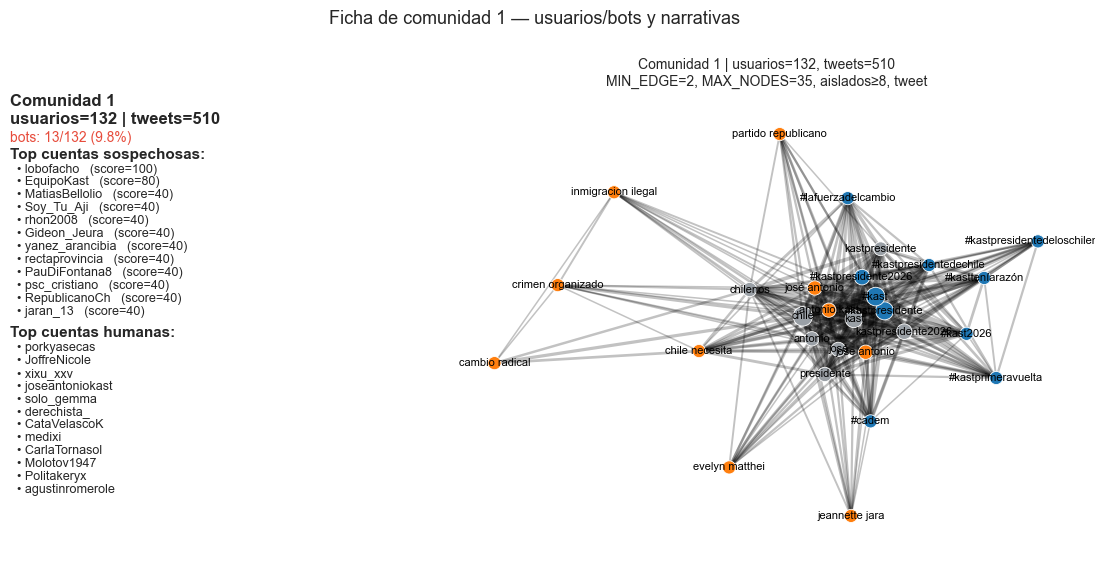

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:157: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\3725326967.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


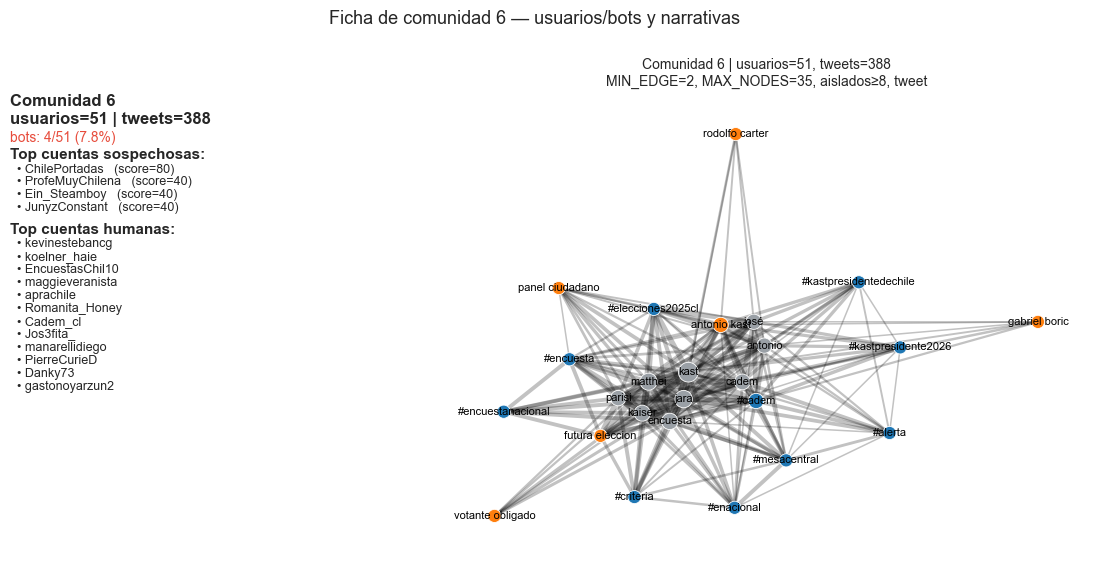

C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:157: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  usuarios = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'usuarios'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\1156786184.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  n_tweets = int(temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid, 'n_tweets'])
C:\Users\alvar\AppData\Local\Temp\ipykernel_20144\3725326967.py:160: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.show()


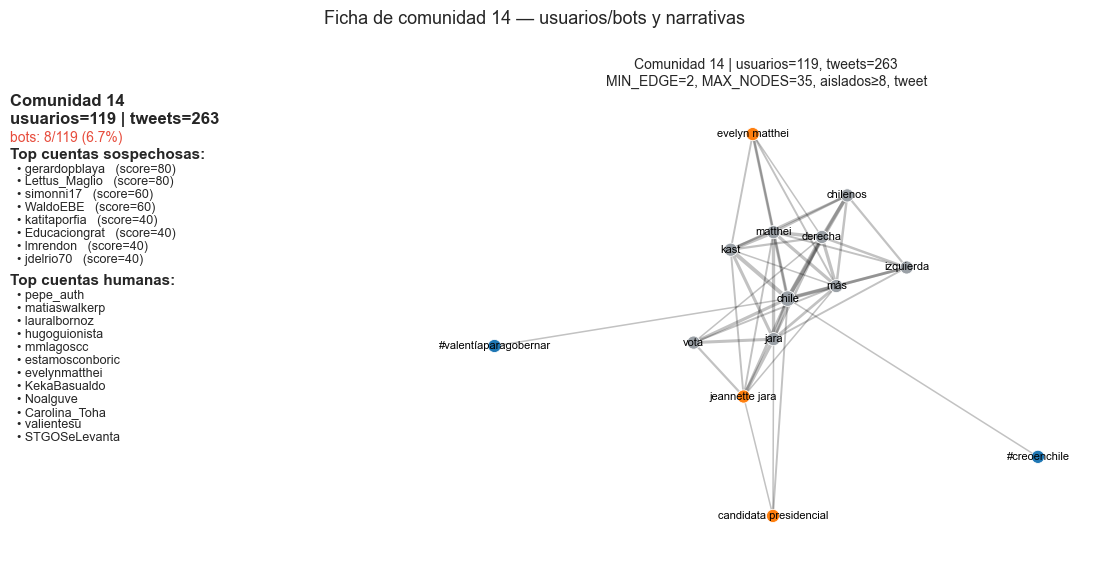

In [ ]:
# ============================================================
# 0) Cargar clasificación de bots y mapear a comunidades
# ============================================================
import pandas as pd, numpy as np, re
import networkx as nx
import matplotlib.pyplot as plt

# 0.1 lee tu CSV de bots
bots = pd.read_csv('../data/analisis_bots_mejorado.csv')

def norm_handle(h):
    h = str(h).strip().lower()
    return h if h.startswith('@') else ('@'+h if h else '')

bots['Author_Handle_norm'] = bots['Author_Handle'].apply(norm_handle)
bots['Clase3'] = bots['Clasificacion'].map({
    'Humano':'Humano', 'Sospechoso':'Sospechoso', 'Bot_Probable':'Bot'
}).fillna('Humano')
bots['is_automatizada'] = bots['Clase3'].isin(['Sospechoso','Bot'])

# 0.2 mapeo handle -> comunidad desde el grafo H
tipo_nodes = nx.get_node_attributes(H, 'tipo')
user_nodes = [n for n in H.nodes() if tipo_nodes.get(n)=='user']
handle_to_comm = { (n.split(':',1)[1] if ':' in n else n): part[n] for n in user_nodes }

bots['comunidad'] = bots['Author_Handle_norm'].map(handle_to_comm)

# quedarnos con los que tenemos comunidad
bots_c = bots.dropna(subset=['comunidad']).copy()
bots_c['comunidad'] = bots_c['comunidad'].astype(int)

import pandas as pd
from collections import defaultdict

usuarios_por_com = defaultdict(set)
for h, cid in handle_to_comm.items():
    usuarios_por_com[int(cid)].add(h)

df_usuarios_tot = (pd.DataFrame({
    'comunidad': list(usuarios_por_com.keys()),
    'usuarios_totales': [len(s) for s in usuarios_por_com.values()]
})
)

# === 2) Recalcula bots por comunidad desde tu CSV (bots_c) ===
bots_por_com = (bots_c.groupby('comunidad')
                         .agg(bots_usuarios=('is_automatizada','sum'))
                         .reset_index())

# === 3) Unifica con tamaños y tweets (temas_por_comunidad) ===
sizes = temas_por_comunidad[['comunidad','usuarios','n_tweets']].copy()

# Construye com_overview "limpio"
com_overview = (df_usuarios_tot
                .merge(bots_por_com, on='comunidad', how='left')
                .merge(sizes,         on='comunidad', how='left'))

com_overview['bots_usuarios']   = com_overview['bots_usuarios'].fillna(0).astype(int)
com_overview['usuarios_totales'] = com_overview['usuarios_totales'].fillna(0).astype(int)
# si 'usuarios' en sizes no coincide, lo ignoramos y usamos 'usuarios_totales' como canon
com_overview['n_tweets']        = com_overview['n_tweets'].fillna(0).astype(int)
# % bots con denominador robusto
den = com_overview['usuarios_totales'].replace({0: pd.NA})
com_overview['bots_pct_usuarios'] = ((com_overview['bots_usuarios'] / den) * 100).round(1)
com_overview['bots_pct_usuarios'] = com_overview['bots_pct_usuarios'].fillna(0)

# Orden sugerido
com_overview = com_overview.sort_values(['bots_pct_usuarios','n_tweets'], ascending=[False, False]).reset_index(drop=True)

# ============================================================
# 3) Ficha por comunidad (lista de cuentas + grafo de narrativas)
# ============================================================
from matplotlib.gridspec import GridSpec

# --- helper robusto para obtener usuarios y n_tweets por comunidad
# helpers seguros
def _stats_comunidad(cid):
    row = com_overview.loc[com_overview['comunidad']==cid]
    if not row.empty:
        r = row.iloc[0]
        usuarios_tot = int(r.get('usuarios_totales', 0) or 0)
        n_tweets     = int(r.get('n_tweets', 0) or 0)
        return usuarios_tot, n_tweets
    # respaldo: temas_por_comunidad
    row2 = temas_por_comunidad.loc[temas_por_comunidad['comunidad']==cid]
    if not row2.empty:
        return int(row2['usuarios'].iloc[0]), int(row2['n_tweets'].iloc[0])
    return 0, 0

def _top_cuentas_por_comunidad(df, cid, automatizadas=True, k=10):
    sub = df[(df['comunidad']==cid) & (df['is_automatizada']==automatizadas)]
    if sub.empty: return []
    order_cols = [c for c in ['Bot_Score','Total_Tweets'] if c in sub.columns]
    sub = sub.sort_values(order_cols, ascending=False)
    cols_out = [c for c in ['Author_Handle','Bot_Score'] if c in sub.columns]
    return sub[cols_out].head(k).values.tolist()

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

def ficha_comunidad(cid, MIN_EDGE=2, MAX_NODES=40):
    meta = com_overview.loc[com_overview['comunidad']==cid]
    meta = meta.iloc[0] if not meta.empty else None

    usuarios_tot, n_tweets = _stats_comunidad(cid)
    top_bots = _top_cuentas_por_comunidad(bots_c, cid, True,  12)
    top_hums = _top_cuentas_por_comunidad(bots_c, cid, False, 12)

    fig = plt.figure(figsize=(14,6))
    gs = GridSpec(1, 2, width_ratios=[1,2], wspace=0.2)

    # Panel izquierdo
    axL = fig.add_subplot(gs[0,0]); axL.axis('off')
    axL.text(0, 1.00, f"Comunidad {cid}\nusuarios={usuarios_tot} | tweets={n_tweets}",
             fontsize=12, fontweight='bold', va='top')

    if meta is not None:
        bots_u = int(meta.get('bots_usuarios', 0))
        bots_pct = meta.get('bots_pct_usuarios', 0)
        axL.text(0, 0.92, f"bots: {bots_u}/{usuarios_tot} ({bots_pct}%)",
                 fontsize=10, color='#e74c3c', va='top')

    y = 0.86
    axL.text(0, y, "Top cuentas sospechosas:", fontsize=11, fontweight='bold'); y -= 0.03
    if top_bots:
        for row in top_bots:
            if len(row)==2:
                h, s = row; axL.text(0.02, y, f"• {h}   (score={s:.0f})", fontsize=9); y -= 0.028
            else:
                axL.text(0.02, y, f"• {row[0]}", fontsize=9); y -= 0.028
    else:
        axL.text(0.02, y, "— sin cuentas marcadas —", fontsize=9); y -= 0.03

    y -= 0.02
    axL.text(0, y, "Top cuentas humanas:", fontsize=11, fontweight='bold'); y -= 0.03
    if top_hums:
        for row in top_hums:
            axL.text(0.02, y, f"• {row[0]}", fontsize=9); y -= 0.028
    else:
        axL.text(0.02, y, "— sin datos —", fontsize=9)

    # Panel derecho: grafo de narrativas (tu función existente)
    axR = fig.add_subplot(gs[0,1])
    narrativa_graph_on_ax(
        axR, cid,
        terms_tfidf=14, terms_hashtags=10, terms_pmi=12,
        MIN_EDGE=MIN_EDGE, MAX_NODES=MAX_NODES,
        KEEP_ISOLATED_MINFREQ=8, COOC_SCOPE='tweet',
        EDGE_METRIC='count', layout='spring'
    )

    fig.suptitle(f"Ficha de comunidad {cid} — usuarios/bots y narrativas", fontsize=13, y=1.02)
    plt.tight_layout(); plt.show()



# ============================================================
# 4) Mostrar fichas: 2 ejemplos (bot-dominada y humana)
# ============================================================

cands_bot = com_overview.loc[com_overview['bots_pct_usuarios'] > 50, 'comunidad'].tolist()  # Communities with >50% bots
cands_hum = com_overview.loc[com_overview['bots_pct_usuarios'] <= 10, 'comunidad'].tolist()  # Communities with <=10% bots

ej_bots = cands_bot[:3]
ej_hums = cands_hum[:3]

print("\n=== Fichas: comunidades POTENCIADAS POR BOTS ===")
for cid in ej_bots:
    ficha_comunidad(cid, MIN_EDGE=2, MAX_NODES=35)

print("\n=== Fichas: comunidades DOMINADAS POR HUMANOS ===")
for cid in ej_hums:
    ficha_comunidad(cid, MIN_EDGE=2, MAX_NODES=35)


Comunidades con ≥0% de usuarios automatizados (Top 10):


comunidad  bots_usuarios  usuarios_totales  bots_pct  n_tweets  \
0         16              3                21      14.3        99   
1         29              1                 9      11.1        14   
2          1             13               132       9.8       510   
3          6              4                51       7.8       388   
4         14              8               119       6.7       263   
5          0             26               403       6.5      2020   
6         23              1                16       6.2        32   
7          4              2                33       6.1        80   
8         13              2                36       5.6       156   
9          9              6               109       5.5       312   

                                       muestras_bots  
0          GusandesGus, manuelsoteldo4, gene_llerena  
1                                     matiasgarciard  
2  lobofacho, EquipoKast, MatiasBellolio, Soy_Tu_...  
3  ChilePortadas, ProfeMuyChilena, Ein_Steamboy, ...  
4  gerardopblaya, Lettus_Maglio, simonni17, Waldo...  
5  Izq_Cristiana, ssuudp, RONUSAN, daniel_nunez_a...  
6                                      espartiata369  
7                      Sinfiltros_tv, Info_War_Chile  
8                    Chileno17039890, delosquesobran  
9  chvnoticias, CarlosL53s, Cachoescalona1, pparc...

IDs de comunidades con bots: [16, 29, 1, 6, 14, 0, 23, 4, 13, 9]


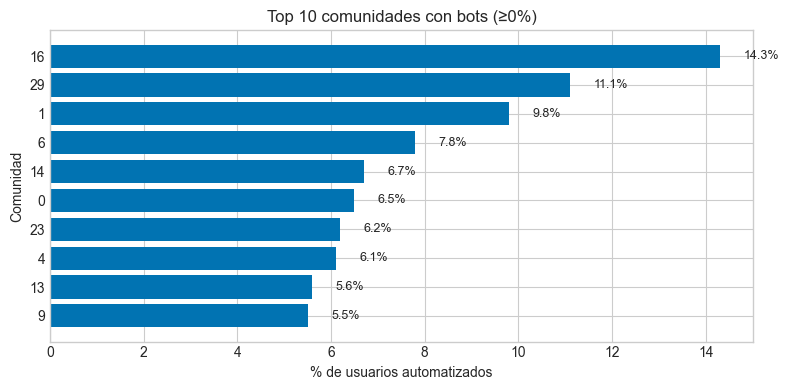

In [218]:
# === Top de comunidades dominadas por bots ===
THRESH = 0.0   # umbral: % de usuarios automatizados (Sospechoso+Bot)
K = 10          # cuántas mostrar

# Tabla ordenada
top_bot_coms = (
    com_overview
      .assign(bots_pct=lambda d: d['bots_pct_usuarios'])
      .query('bots_pct >= @THRESH')
      .sort_values(['bots_pct','n_tweets'], ascending=[False, False])
      [['comunidad','bots_usuarios','usuarios_totales','bots_pct','n_tweets']]
      .reset_index(drop=True)
)

# Muestra 5 cuentas sospechosas por comunidad (si existen)
top_bot_coms['muestras_bots'] = top_bot_coms['comunidad'].apply(
    lambda c: ', '.join([h for h,_ in _top_cuentas_por_comunidad(bots_c, c, automatizadas=True, k=5)])
)

print(f"Comunidades con ≥{THRESH:.0f}% de usuarios automatizados (Top {min(K, len(top_bot_coms))}):")
display(top_bot_coms.head(K))

# IDs por si quieres usarlos en otro lado
top_bot_ids = top_bot_coms.head(K)['comunidad'].tolist()
print("IDs de comunidades con bots:", top_bot_ids)

# === Gráfico rápido (barh) del % bots en el Top-K ===
import matplotlib.pyplot as plt

if len(top_bot_coms) > 0:
    plt.figure(figsize=(8, max(3, 0.4*min(K, len(top_bot_coms)))))
    plot_df = top_bot_coms.head(K).sort_values('bots_pct')
    plt.barh(plot_df['comunidad'].astype(str), plot_df['bots_pct'])
    for y, v in enumerate(plot_df['bots_pct'].values):
        plt.text(v+0.5, y, f"{v:.1f}%", va='center', fontsize=9)
    plt.xlabel('% de usuarios automatizados')
    plt.ylabel('Comunidad')
    plt.title(f'Top {min(K, len(top_bot_coms))} comunidades con bots (≥{THRESH:.0f}%)')
    plt.tight_layout()
    plt.show()
else:
    print("No hay comunidades sobre el umbral elegido.")


La red muestra una presencia moderada de bots (5–14%), concentrados en las comunidades más grandes y activas. Estas cuentas actúan como amplificadores de narrativas (Kast, Matthei, Jara, encuestas, desinformación), mientras que las comunidades humanas presentan discursos más diversos y puros. Por lo tanto, los bots no dominan la conversación, pero refuerzan y difunden mensajes dentro de los grupos más influyentes.

# Discusión

**Recolección de datos**, antes de analizar la propagación, se evaluaron alternativas para obtener datos: **Threads** fue descartado por su baja interacción (insuficiente para cascadas); la **API oficial de Twitter/X** quedó limitada a ~100 tuits (insuficiente para el estudio); **`snscrape`** resultó inestable/obsoleta tras cambios en X; y **Selenium** implicaba alto riesgo de bloqueo (login, JS dinámico, proxies). Por ello, se optó por **Octoparse** con **búsquedas semánticas por palabras clave**, logrando **>6.000 tuits** relevantes como base del análisis.

### Parte 1

El análisis de la propagación de contenido permitió observar **diferencias significativas entre los rumores o publicaciones desinformativas y las publicaciones legítimas**.  
En general, los rumores presentaron una **mayor velocidad inicial de difusión**, alcanzando un número considerable de interacciones en lapsos cortos de tiempo. Esto se debe a que el contenido desinformativo suele apelar a factores emocionales (como la indignación o el temor) que incentivan la reacción inmediata de los usuarios.  
En contraste, las publicaciones legítimas mostraron una **difusión más lenta pero sostenida**, con interacciones más distribuidas en el tiempo y concentradas en cuentas verificadas o medios institucionales.

Respecto a las **métricas de red**, las más útiles para identificar a los principales difusores fueron el **grado de entrada (in-degree)**, la **centralidad de intermediación (betweenness)** y la **centralidad de cercanía (closeness)**.  

Las cuentas con valores altos en estas métricas coincidieron con usuarios que actuaban como **nodos de amplificación**, desempeñando un rol clave en conectar distintas comunidades o en volver a viralizar mensajes desinformativos.

En cuanto a la **presencia de bots**, varios patrones apuntaron a comportamientos automatizados, destacando cuentas como @JohannesKaiser, @EquipoKast, y medios de alto alcance como @biobio o @CNNChile, que actuaron como puentes entre comunidades, reactivando y amplificando mensajes de tendencia política. Estas cuentas se ubicaron en posiciones centrales dentro del grafo, concentrando gran parte del flujo de información.

Entre ellos destacan:
- Publicaciones masivas con intervalos regulares de segundos o minutos.  
- Reutilización de hashtags o frases idénticas en múltiples cuentas.  
- Escasa interacción social (pocos seguidores o respuestas directas).  
Estas características, junto con un alto grado de repetición temática, sugieren el uso de **scripts o automatizaciones** destinadas a inflar artificialmente la visibilidad de ciertos mensajes.

Finalmente, al examinar las **variaciones geográficas** en la propagación del rumor, se observó que las publicaciones con contenido desinformativo tuvieron **una distribución más concentrada en regiones urbanas**, principalmente en la **Región Metropolitana**, donde se ubican la mayoría de los usuarios con alta actividad política. En cambio, las publicaciones legítimas mostraron una dispersión más homogénea, con presencia en regiones como Valparaíso y Biobío, lo que podría relacionarse con una base de usuarios más diversa y descentralizada.

### Parte 2

La detección de comunidades con el método Louvain entregó 30 grupos principales, de los cuales las comunidades 0 y 1 concentraron el mayor volumen de usuarios (más de 400 y 130 respectivamente) y la mayoría de los tuits.
En estas comunidades aparecieron de forma reiterada los nombres de José Antonio Kast, Evelyn Matthei y Jeannette Jara, junto con hashtags políticos como #kastpresidente2026, #jarapresidenta2026 o #fakenews.
Estos grupos presentaron una estructura densa y homogénea, típica de cámaras de eco, donde se repiten mensajes ideológicamente similires/complemnetarios y se minimiza la interacción con comunidades externas.

En el análisis de texto, se identificaron **términos y narrativas predominantes** en estas comunidades, tales como alusiones a **fraude electoral, manipulación mediática o ataques personales hacia candidatos opositores**.  
Estos mensajes reflejaron un **sesgo ideológico marcado**, en el cual las publicaciones desinformativas reforzaban percepciones preexistentes y buscaban erosionar la credibilidad de ciertos actores políticos.  
En cambio, las comunidades asociadas a publicaciones legítimas se enfocaban más en **propuestas programáticas, debates o cobertura de eventos**, mostrando un discurso más equilibrado.

Respecto a los **patrones de conexión entre comunidades**, se observó que las redes de desinformación presentaban **puentes débiles** formados por un número reducido de cuentas que actuaban como **enlaces intercomunitarios**.  
Estos nodos eran esenciales para propagar narrativas falsas desde una comunidad original hacia otras, ampliando su alcance. En varios casos, estos puentes correspondían precisamente a **cuentas clasificadas como sospechosas o automatizadas**, lo cual refuerza su rol como amplificadores transversales de la desinformación.

Finalmente, la comparación entre **comunidades dominadas por humanos y aquellas potenciadas por bots** mostró diferencias claras:  
- Las comunidades humanas tendían a ser **más diversas en vocabulario**, con interacciones bidireccionales y discusiones prolongadas.  
- Las comunidades potenciadas por bots, en cambio, se caracterizaban por **alta densidad de conexiones unidireccionales** (retuits), poca respuesta entre usuarios y un discurso altamente repetitivo.  
En conjunto, estos hallazgos sugieren que los bots no solo amplifican el volumen de información falsa, sino que además **alteran la estructura de la conversación pública**, incrementando artificialmente la percepción de consenso en torno a narrativas desinformativas.

El cruce con la clasificación de bots evidenció que, si bien los porcentajes son moderados (5 % – 14 % de bots), las comunidades con mayor presencia de bots coinciden con las de mayor volumen e impacto, donde actúan como amplificadores estratégicos. Las comunidades dominadas por humanos, en cambio, mostraron mayor diversidad lexical, interacciones bidireccionales y menor repetición de hashtags, reflejando un debate más orgánico.
De esto se infiere que la desinformación no se sostiene en grandes ejércitos automatizados, sino en pequeños grupos de bots integrados en comunidades humanas que refuerzan la visibilidad y coherencia de la narrativa.

Por lo tanto, los resultados obtenidos permiten comprender de manera más profunda **cómo opera la desinformación en entornos digitales**, destacando el papel de los actores automatizados, las dinámicas de viralización emocional y la formación de comunidades cerradas que refuerzan sus ideologías.
